Predicting whether or not a consumer will default on their loan

Data from: https://www.kaggle.com/competitions/GiveMeSomeCredit/overview

## Table of Contents

- [1. Loading in data](#section-1)
- - [1. 1 packages and data](#section-1.1)
- - [1. 2 transforming data for inspection](#section-1.2)
- [2. Visualising and summarising the data](#section-2)
- - [2. 1 graphing the variables](#section-2.1)
- - [2. 2 Notes about the population](#section-2.2)
- [3. Calculating Weight of Evidence and Information Values](#section-3)
- [4. Building a model](#section-4)
- - [4. 1 Preparing data input](#section-4.1)
- - [4. 2 Creating models](#section-4.2)
- - [4. 3 Gathering results](#section-4.3)
- - [4. 4 ROC, AUC and score](#section-4.4)
- [5. Analysis of models results](#section-5)
- [6. Creating final model](#section-6)

In [1]:
%%html
<a id="section-1"></a>

### Section 1: Loading in Data

First load in relevant libraries and data:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from xgboost import XGBClassifier
import statsmodels.api as sm

Load in data. Adjust for file location

In [3]:
#enter the file location and the file name below. Assumes that the data has not been renamed.
data_folder = "C:/Users/Sandy/Documents/Datasets/Kaggle/Paidy credit test/"
#data_folder = "C:/Users/shinc/OneDrive/Documents/Datasets/Paidy credit test/GiveMeSomeCredit/"
raw_data_file = "cs-training.csv"
data_path = os.path.join(data_folder ,raw_data_file)

raw_credit_training_data = pd.read_csv(data_path)

Let's have a quick look at the data:

In [4]:
raw_credit_training_data.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
pd.set_option('display.float_format', '{:.2f}'.format)#In order to remove standard form
raw_credit_training_data.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.00,150000.00,150000.00,150000.00,150000.00,150000.00,120269.00,150000.00,150000.00,150000.00,150000.00,146076.00
mean,75000.50,0.07,6.05,52.30,0.42,353.01,6670.22,8.45,0.27,1.02,0.24,0.76
std,43301.41,0.25,249.76,14.77,4.19,2037.82,14384.67,5.15,4.17,1.13,4.16,1.12
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,37500.75,0.00,0.03,41.00,0.00,0.18,3400.00,5.00,0.00,0.00,0.00,0.00
50%,75000.50,0.00,0.15,52.00,0.00,0.37,5400.00,8.00,0.00,1.00,0.00,0.00
75%,112500.25,0.00,0.56,63.00,0.00,0.87,8249.00,11.00,0.00,2.00,0.00,1.00
max,150000.00,1.00,50708.00,109.00,98.00,329664.00,3008750.00,58.00,98.00,54.00,98.00,20.00


Let's visualise the data in boxplots too.

RevolvingUtilizationOfUnsecuredLines


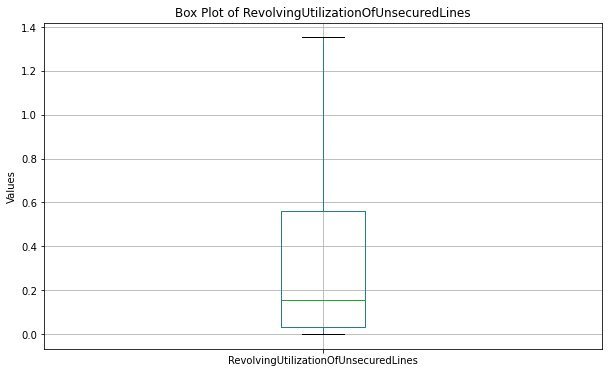

age


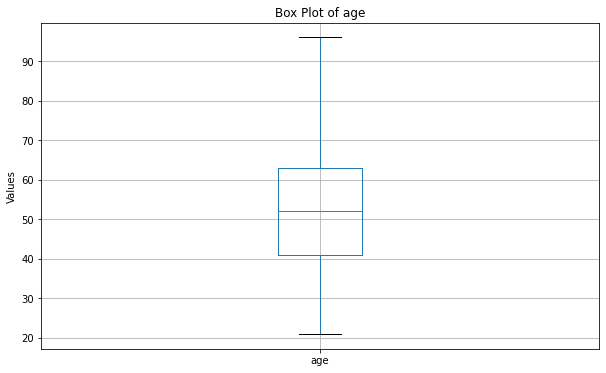

NumberOfTime30-59DaysPastDueNotWorse


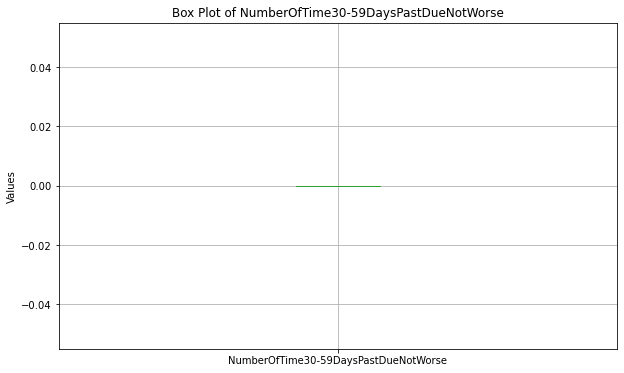

DebtRatio


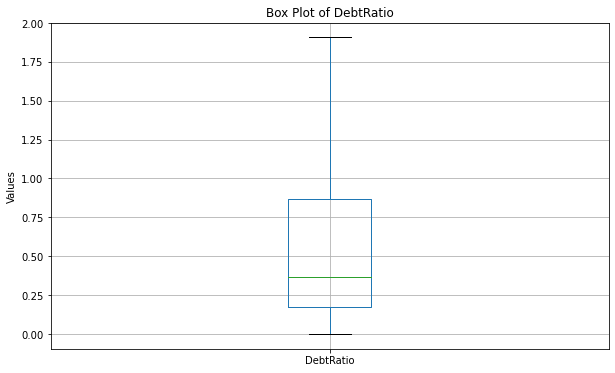

MonthlyIncome


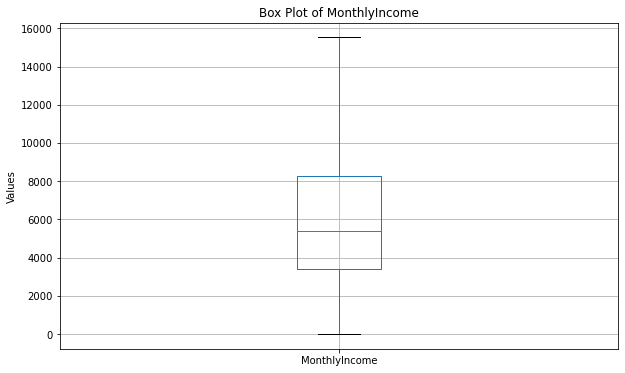

NumberOfOpenCreditLinesAndLoans


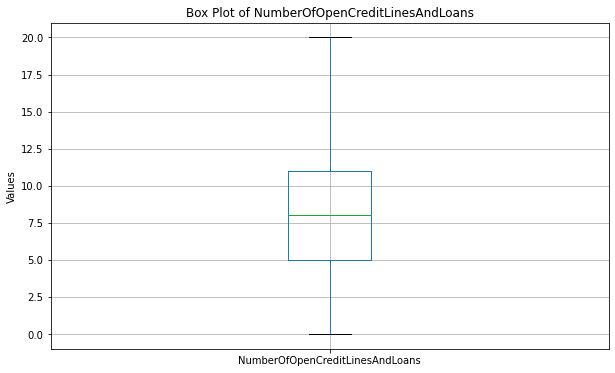

NumberOfTimes90DaysLate


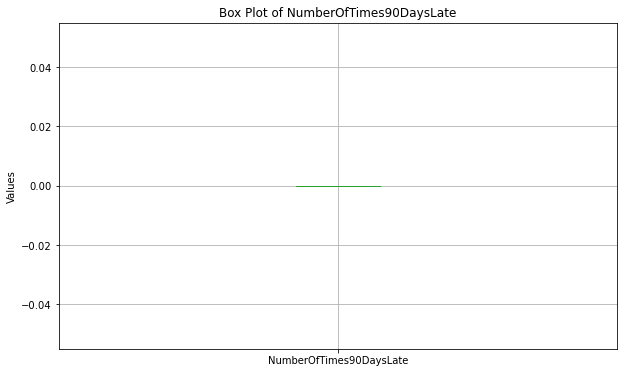

NumberRealEstateLoansOrLines


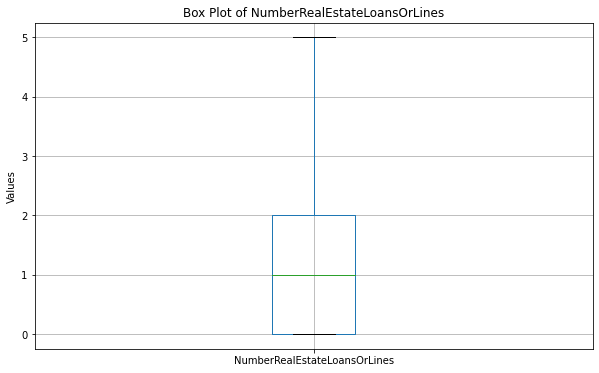

NumberOfTime60-89DaysPastDueNotWorse


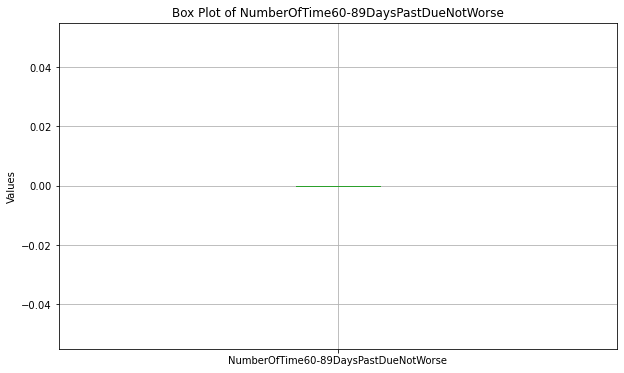

NumberOfDependents


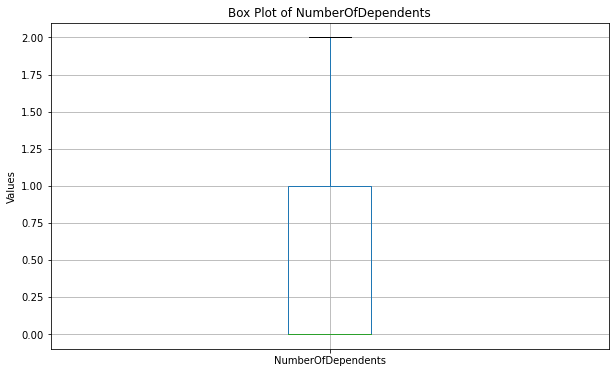

In [6]:
boxplot=raw_credit_training_data.drop(['Unnamed: 0','SeriousDlqin2yrs'], axis=1)
for var in boxplot:
    print(var)
    plt.figure(figsize=(10, 6))
    #The below boxplot arguments are to limit the y-axis, as showing extreme values can make the box plot hard to see
    boxplot[var].to_frame().boxplot(sym='', showfliers=False)
    plt.title(f'Box Plot of {var}')
    plt.ylabel('Values')
    plt.show()

Notable points:

RevolvingUtilizationOfUnsecuredLines has a max that exceeds 1, i.e. somehow there is a data point where the balance much exceeds the credit limit. One possible reason is the existence of unarranged overdrafts.

Minimum age of 0 should possibly be addressed

Debt Ratio=(Debt+living expenses etc)/MonthlyIncome. Debt ratio shows monthly income is usually higher than monthly debt owed, but there are exceptions.

MonthlyIncome seems to be moderate, assuming the currency is USD. Perhaps indicates some affluence of customers.

NumberOfOpenCreditLinesAndLoans max (58) may be suspicious, as taking out many loans (with no plans to pay back) is a common form of fraud. However, that customer did not flag as receiving SeriousDlqin2yrs, so may just be an abnormally large datapoint.

NumberRealEstateLoansOrLines shows the audience has some level of affluence, with the mean/median value being slightly higher than 1. % of customers with at least 1 is around 63%.

Dependents: Most people seem not have dependents..

NumberOfTimes90DaysLate: Comparing to the other variable names, NumberOfTimes30-59/60-89DaysPastDueNotWorse, perhaps this indicates that default is 90+ days late, and not, say, ~120 days late, like some financial institutions. On the other hand, it could be intepreted as 90-X days where X is default.With that assumption, this variable should be very predicative of a customer's defaulting behaviour.

NumberOfTimes30-59DaysPastDueNotWorse: May give some indication of defaulting behaviour, though if no record of further delay, may not be cause for concern, as many people simply forget to pay.

NumberOfTimes60-89DaysPastDueNotWorse: Should be a moderate indicator of delinquency.

Perhaps one could compare mortgages and monthly income to see what year the data is roughly from. From there can get economic data for economic forecasts etc


In [7]:
len(raw_credit_training_data[raw_credit_training_data['NumberOfTimes90DaysLate']>0])

8338

In [8]:
len(raw_credit_training_data[raw_credit_training_data['SeriousDlqin2yrs']==1]) \
/len(raw_credit_training_data[raw_credit_training_data['NumberOfTimes90DaysLate']>0])

1.2024466298872631

In [9]:
raw_credit_training_data[raw_credit_training_data['NumberOfOpenCreditLinesAndLoans']==58]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
30587,30588,0,0.00,53,0,5.97,8000.00,58,0,54,0,0.00


Perhaps NumberOfTimes90DaysLate is from a different data source

There are more people who default in the next two years than people who have defaulted in the past. This may make sense as people are given more time to default.

Let's have a look at the correlation between variables:

In [10]:
column_names=raw_credit_training_data.columns
print(column_names)

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')


Firstly, let's changed the 'Unnamed' column to id:

In [11]:
raw_credit_training_data.rename( columns={'Unnamed: 0':'id'}, inplace=True)

In [12]:
corr_matrix=raw_credit_training_data.drop(['id'], axis=1).corr()
corr_matrix

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.00,-0.00,-0.12,0.13,-0.01,-0.02,-0.03,0.12,-0.01,0.10,0.05
RevolvingUtilizationOfUnsecuredLines,-0.00,1.00,-0.01,-0.00,0.00,0.01,-0.01,-0.00,0.01,-0.00,0.00
age,-0.12,-0.01,1.00,-0.06,0.02,0.04,0.15,-0.06,0.03,-0.06,-0.21
NumberOfTime30-59DaysPastDueNotWorse,0.13,-0.00,-0.06,1.00,-0.01,-0.01,-0.06,0.98,-0.03,0.99,-0.00
DebtRatio,-0.01,0.00,0.02,-0.01,1.00,-0.03,0.05,-0.01,0.12,-0.01,-0.04
MonthlyIncome,-0.02,0.01,0.04,-0.01,-0.03,1.00,0.09,-0.01,0.12,-0.01,0.06
NumberOfOpenCreditLinesAndLoans,-0.03,-0.01,0.15,-0.06,0.05,0.09,1.00,-0.08,0.43,-0.07,0.07
NumberOfTimes90DaysLate,0.12,-0.00,-0.06,0.98,-0.01,-0.01,-0.08,1.00,-0.05,0.99,-0.01
NumberRealEstateLoansOrLines,-0.01,0.01,0.03,-0.03,0.12,0.12,0.43,-0.05,1.00,-0.04,0.12
NumberOfTime60-89DaysPastDueNotWorse,0.10,-0.00,-0.06,0.99,-0.01,-0.01,-0.07,0.99,-0.04,1.00,-0.01


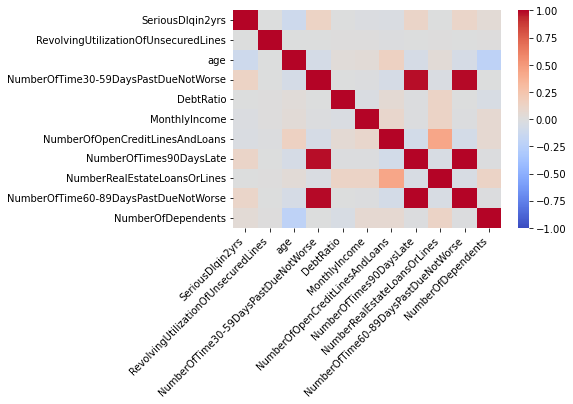

In [13]:
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='coolwarm', ) # Optional annot=True to include values, lw=1, mask=matrix for only half the table (since in correlation heatmap half is duplicated)
# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

# Rotate the y-axis labels
plt.yticks(rotation=0)

plt.show()

High correlation pairs include:

NumberOfTimes90DaysLate and both NumberOfTimes30-59 and 60-89 DaysPastDueNotWorse

NumberRealEstateLoansOrLines and NumberOfOpenCreditLinesAndLoans - If the first is open lines only, then one is a subset of the other.

All others are <0.3

In [14]:
%%html
<a id="section-1.2"></a>

Let's check the data types to see if they agree with the data dictionary.

In [15]:
# Extract data types
column_info = raw_credit_training_data.dtypes.reset_index()
column_info.columns = ['Column Name', 'Data Type']
print(column_info)

                             Column Name Data Type
0                                     id     int64
1                       SeriousDlqin2yrs     int64
2   RevolvingUtilizationOfUnsecuredLines   float64
3                                    age     int64
4   NumberOfTime30-59DaysPastDueNotWorse     int64
5                              DebtRatio   float64
6                          MonthlyIncome   float64
7        NumberOfOpenCreditLinesAndLoans     int64
8                NumberOfTimes90DaysLate     int64
9           NumberRealEstateLoansOrLines     int64
10  NumberOfTime60-89DaysPastDueNotWorse     int64
11                    NumberOfDependents   float64


In [16]:
column_info.to_clipboard()

Let's check each variable for NaN/Null/Missing values, in case we need to transform the data

In [17]:
null_value_sum=raw_credit_training_data.isna().sum()
null_value_pct=raw_credit_training_data.isna().mean()
print(null_value_sum)
print(null_value_pct)

id                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64
id                                     0.00
SeriousDlqin2yrs                       0.00
RevolvingUtilizationOfUnsecuredLines   0.00
age                                    0.00
NumberOfTime30-59DaysPastDueNotWorse   0.00
DebtRatio                              0.00
MonthlyIncome                          0.20
NumberOfOpenCreditLinesAndLoans        0.00
NumberOfTimes90DaysLate                0.00
NumberRealEstateLoansOrLines           

Let's change MonthlyIncome and NumberOfDependents NaN values to -1 for easier processing and categorisation.
First ensure there are no other negative values:

In [18]:
raw_credit_training_data['NumberOfDependents'].unique()

array([ 2.,  1.,  0., nan,  3.,  4.,  5.,  6.,  8.,  7., 20., 10.,  9.,
       13.])

In [19]:
len(raw_credit_training_data[raw_credit_training_data['MonthlyIncome']<0])

0

So neither NumberOfDependents nor MonthlyIncome have negative values, so we can re-categorise missing values as -1.

In [20]:
raw_credit_training_data['NumberOfDependents'].fillna(-1, inplace=True)
raw_credit_training_data['NumberOfDependents']=raw_credit_training_data['NumberOfDependents'].astype(int) #change type to int to match data dictionary
raw_credit_training_data['MonthlyIncome'] = raw_credit_training_data['MonthlyIncome'].fillna(-1)

In [21]:
%%html
<a id="section-2"></a>

## Visualising the data

Let's make a function that graphs our desired variable against the dependent variable SeriousDlqin2yrs

In [22]:
#Group by var categories and plot %s vs y_var
#Label bars with sample size too
def graph_vars(var, y_var='SeriousDlqin2yrs', df=raw_credit_training_data):
    pct_var = df.groupby([var, y_var]).size() / df.groupby(var).size()
    pct_var = pct_var.unstack().fillna(0)
    
    sample_count_df = df.groupby(var).size()
    
    # Create a bar chart
    ax=pct_var.plot(kind='bar', stacked=True, alpha=0.7, figsize=(14, 6))
    
    # Set labels and title
    plt.xlabel(var)
    plt.ylabel(y_var)
    plt.title(f'Percentage of {var} seriously delinquent or not')
    
    # Display the bar chart
    plt.legend(title=f'%{var} vs {y_var}', labels=['0', '1'], loc='lower left')
    # Annotate the bars with sample size
    for p, count in zip(ax.patches, sample_count_df):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(count, (x + width / 2, y + height), ha='center')

    plt.show()

To make the above useful for a continuous variable, we need to place the data into buckets change it into categorical data:

Note that these buckets were determined by looking at the `raw_credit_training_data.describe()` table

In [23]:
var='MonthlyIncome'

MonthlyIncome_bin_edges = [-1, 0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, float('inf')]
MonthlyIncome_bin_labels = ['Null', '0-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000', '5000-6000', '6000-7000', '7000-8000', '8000-9000', '9000-10000', '10000+']

raw_credit_training_data['MonthlyIncome_bin'] = pd.cut(raw_credit_training_data[var], bins=MonthlyIncome_bin_edges, labels=MonthlyIncome_bin_labels, include_lowest=True)

In [24]:
var='DebtRatio'

DebtRatio_bin_edges=[0, 0.2, 0.4, 0.6, 0.8, 1.0, 5, 10, float('inf')]
DebtRatio_bin_labels=['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0', '1.0-5.0', '5.0-10.0', '10+']

# Use pd.cut() to categorize the variable
raw_credit_training_data['DebtRatio_bin'] = pd.cut(raw_credit_training_data[var], bins=DebtRatio_bin_edges, labels=DebtRatio_bin_labels, include_lowest=True)

In [25]:
var='RevolvingUtilizationOfUnsecuredLines'

RevolvingUtilizationOfUnsecuredLines_bin_edges=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0, 10.0, float('inf')]
RevolvingUtilizationOfUnsecuredLines_bin_labels=['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0', '1.0-5.0','5.0-10.0', '10+']

# Use pd.cut() to categorize the variable
raw_credit_training_data['RevolvingUtilizationOfUnsecuredLines_bin'] = pd.cut(raw_credit_training_data[var], bins=RevolvingUtilizationOfUnsecuredLines_bin_edges, labels=RevolvingUtilizationOfUnsecuredLines_bin_labels, include_lowest=True)

Plot the now-categorised continuous variables:

Discussion on the variable graphs is after all the variables have been binned.

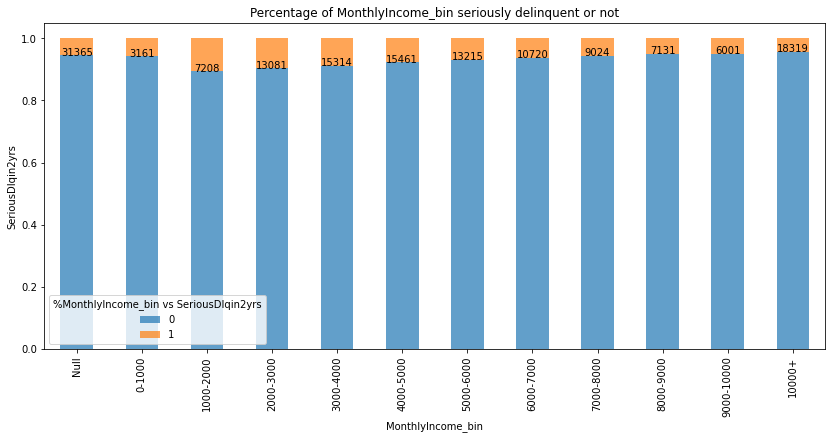

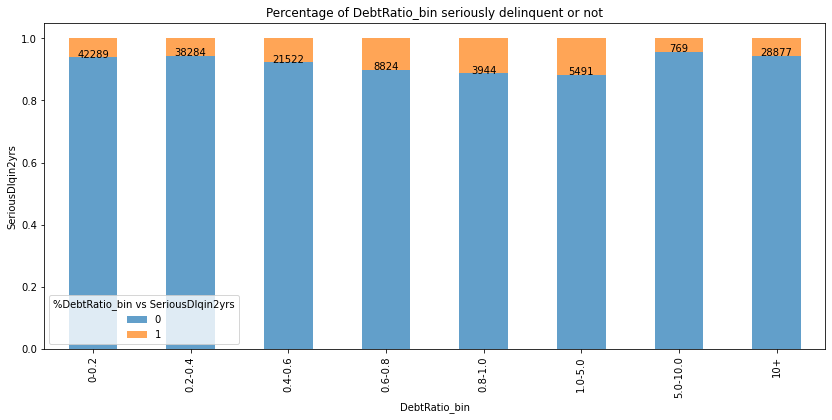

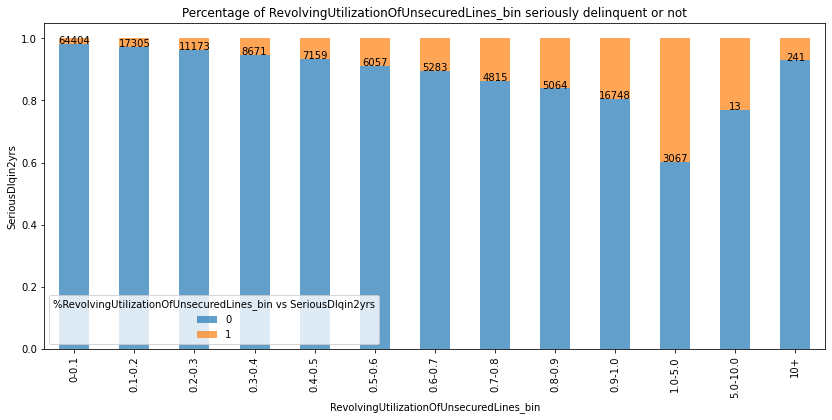

In [26]:
cont_vars=['MonthlyIncome_bin','DebtRatio_bin','RevolvingUtilizationOfUnsecuredLines_bin']
for var in cont_vars:
    graph_vars(var)

Now let's plot the integer variables.

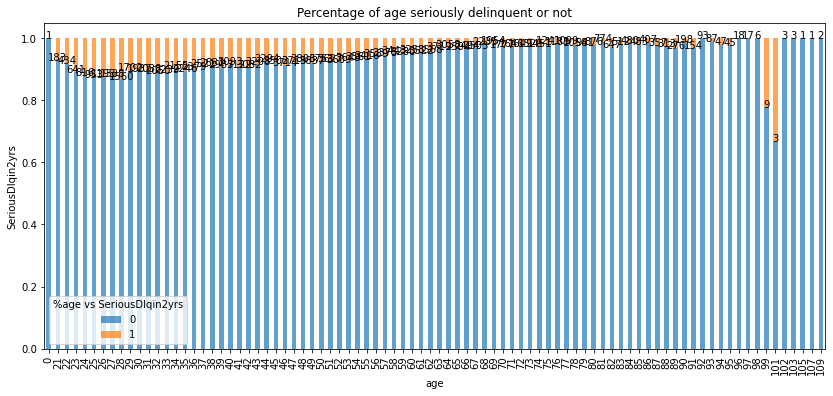

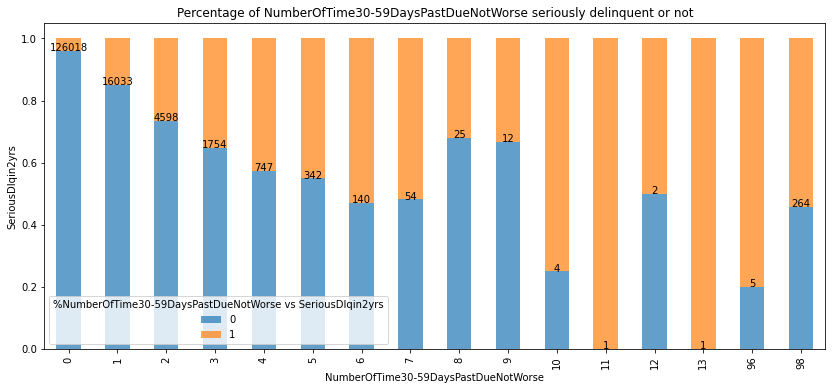

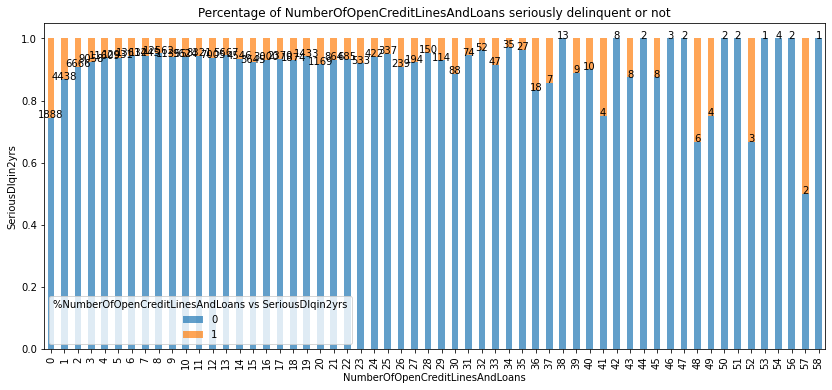

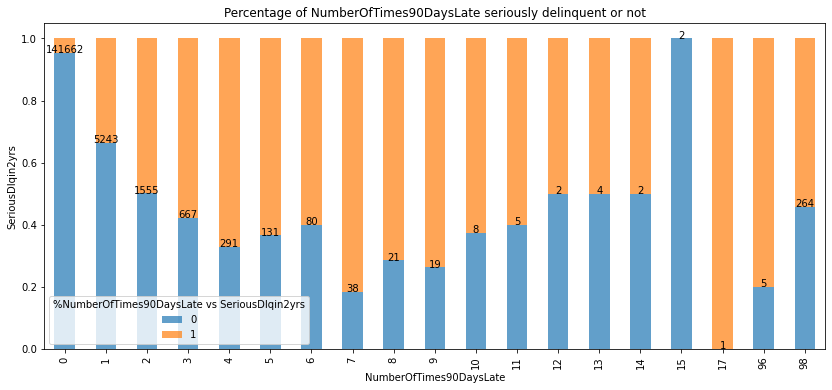

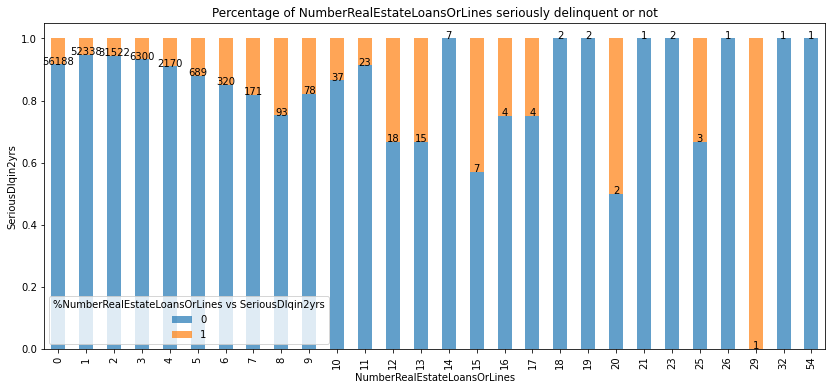

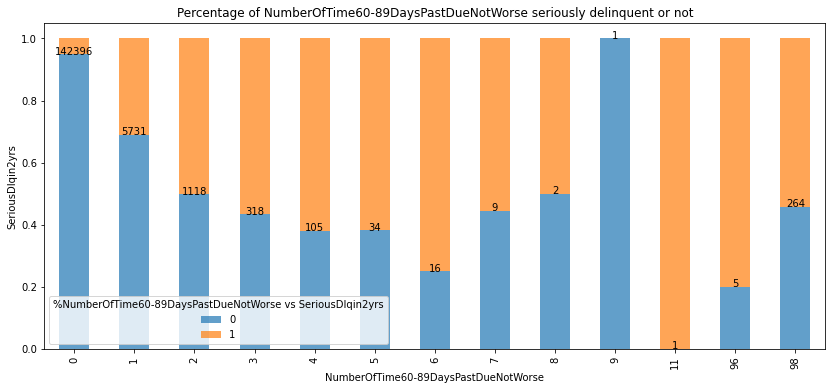

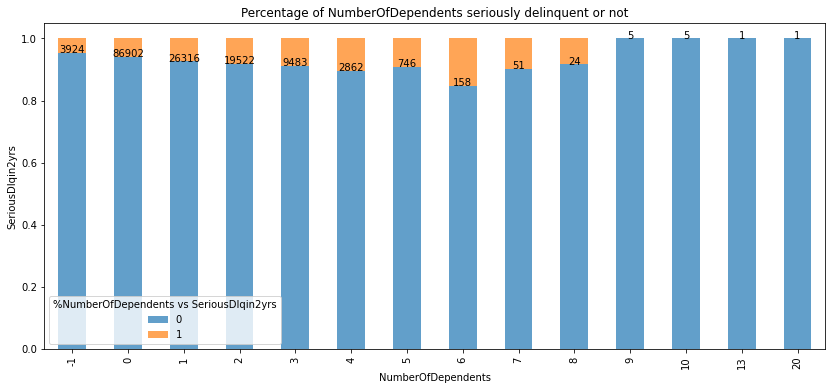

In [27]:
int_vars=['age','NumberOfTime30-59DaysPastDueNotWorse',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']
for var in int_vars:
    graph_vars(var)

The NumberOfTimeX-YDaysLateNotWorse variables have many a gap between smaller values and 97 and 98, indicating that 97 and 98 may be some sort of special status code for this variable.

From the above graphs, lets try to put these variables into buckets, grouping together adjacent bars with a similar rate of % delinquency

In [28]:
#age:
age_bin_edges = [0, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, float('inf')]  # Define your custom bin edges
age_bin_labels = ['0-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65', '66-70', '71-75', '76-80', '81+']  # Define labels for each bin

raw_credit_training_data['age_bin'] = pd.cut(raw_credit_training_data['age'], bins=age_bin_edges, labels=age_bin_labels, include_lowest=True)

In [29]:
#NumberOfDependents: Low sample sizes above 8 so grouped together with those before it
NumDepend_bin_edges = [-1, 0, 1, 2, 3, 4, float('inf')]
NumDepend_bin_labels = ['Missing', '0', '1', '2', '3', '4+']

raw_credit_training_data['NumDepend_bin'] = pd.cut(raw_credit_training_data['NumberOfDependents'], bins=NumDepend_bin_edges, labels=NumDepend_bin_labels, include_lowest=True)

In [30]:
#NumberOfTime30-59DaysPastDueNotWorse: Group 5+ together as similar default rate
Num30to59_bin_edges = [-1, 0, 1, 2, 3, 4, 5, float('inf')]  # Define your custom bin edges
Num30to59_bin_labels = ['0', '1', '2', '3', '4', '5', '5+']  # Define labels for each bin

raw_credit_training_data['Num30to59_bin'] = pd.cut(raw_credit_training_data['NumberOfTime30-59DaysPastDueNotWorse'], bins=Num30to59_bin_edges, labels=Num30to59_bin_labels)

In [31]:
#NumberOfOpenCreditLinesAndLoans:
NumCredLineLoan_bin_edges = [-1, 0, 1, 2, 3, 4, float('inf')]  # Define your custom bin edges
NumCredLineLoan_bin_labels = ['0', '1', '2', '3', '4', '4+']  # Define labels for each bin

raw_credit_training_data['NumCredLineLoan_bin'] = pd.cut(raw_credit_training_data['NumberOfOpenCreditLinesAndLoans'], bins=NumCredLineLoan_bin_edges, labels=NumCredLineLoan_bin_labels)

In [32]:
#NumberRealEstateLoansOrLines
NumRealEstate_bin_edges = [-1, 0, 1, 2, 3, 4, 5, 6, float('inf')]  # Define your custom bin edges
NumRealEstate_bin_labels = ['0', '1', '2', '3', '4', '5', '6', '6+']  # Define labels for each bin

raw_credit_training_data['NumRealEstate_bin'] = pd.cut(raw_credit_training_data['NumberRealEstateLoansOrLines'], bins=NumRealEstate_bin_edges, labels=NumRealEstate_bin_labels)

In [33]:
#NumberOfTime60-89DaysPastDueNotWorse
Num60to90_bin_edges = [-1, 0, 1, 2, 3, 4, 97, 98, float('inf')]  # Define your custom bin edges
Num60to90_bin_labels = ['0', '1', '2', '3', '4', '4-97', '98', '98+']  # Define labels for each bin

raw_credit_training_data['Num60to90_bin'] = pd.cut(raw_credit_training_data['NumberOfTime60-89DaysPastDueNotWorse'], bins=Num60to90_bin_edges, labels=Num60to90_bin_labels)

In [34]:
#NumberOfTime30-59DaysPastDueNotWorse: Group 5+ together as similar default rate
Num30to59_bin_edges = [-1, 0, 1, 2, 3, 4, 5, float('inf')]  # Define your custom bin edges
Num30to59_bin_labels = ['0', '1', '2', '3', '4', '5', '5+']  # Define labels for each bin

raw_credit_training_data['Num30to59_bin'] = pd.cut(raw_credit_training_data['NumberOfTime30-59DaysPastDueNotWorse'], bins=Num30to59_bin_edges, labels=Num30to59_bin_labels)

In [35]:
#NumberOfOpenCreditLinesAndLoans:
NumCredLineLoan_bin_edges = [-1, 0, 1, 2, 3, 4, float('inf')]  # Define your custom bin edges
NumCredLineLoan_bin_labels = ['0', '1', '2', '3', '4', '4+']  # Define labels for each bin

raw_credit_training_data['NumCredLineLoan_bin'] = pd.cut(raw_credit_training_data['NumberOfOpenCreditLinesAndLoans'], bins=NumCredLineLoan_bin_edges, labels=NumCredLineLoan_bin_labels)

In [36]:
#NumberOfTimes90DaysLate:
Num90DaysLate_bin_edges = [-1, 0, 1, 2, 3, float('inf')]  # Define your custom bin edges
Num90DaysLate_bin_labels = ['0', '1', '2', '3', '3+']  # Define labels for each bin

raw_credit_training_data['Num90DaysLate_bin'] = pd.cut(raw_credit_training_data['NumberOfTimes90DaysLate'], bins=Num90DaysLate_bin_edges, labels=Num90DaysLate_bin_labels)

In [37]:
#NumberRealEstateLoansOrLines
NumRealEstate_bin_edges = [-1, 0, 1, 2, 3, 4, 5, 6, float('inf')]  # Define your custom bin edges
NumRealEstate_bin_labels = ['0', '1', '2', '3', '4', '5', '6', '6+']  # Define labels for each bin

raw_credit_training_data['NumRealEstate_bin'] = pd.cut(raw_credit_training_data['NumberRealEstateLoansOrLines'], bins=NumRealEstate_bin_edges, labels=NumRealEstate_bin_labels)

In [38]:
#NumberOfTime60-89DaysPastDueNotWorse
Num60to90_bin_edges = [-1, 0, 1, 2, 3, 4, 97, 98, float('inf')]  # Define your custom bin edges
Num60to90_bin_labels = ['0', '1', '2', '3', '4', '5-97', '98', '98+']  # Define labels for each bin

raw_credit_training_data['Num60to90_bin'] = pd.cut(raw_credit_training_data['NumberOfTime60-89DaysPastDueNotWorse'], bins=Num60to90_bin_edges, labels=Num60to90_bin_labels)

In [39]:
bin_list=['age_bin', 'Num30to59_bin', 'NumCredLineLoan_bin',
          'Num90DaysLate_bin', 'NumRealEstate_bin', 'Num60to90_bin',
          'NumDepend_bin', 'MonthlyIncome_bin', 'DebtRatio_bin',
          'RevolvingUtilizationOfUnsecuredLines_bin']

In [40]:
%%html
<a id="section-2.1"></a>

Let's graph the now bucketed variables. The continuous variables will be plotted again to get all graphs in the same place

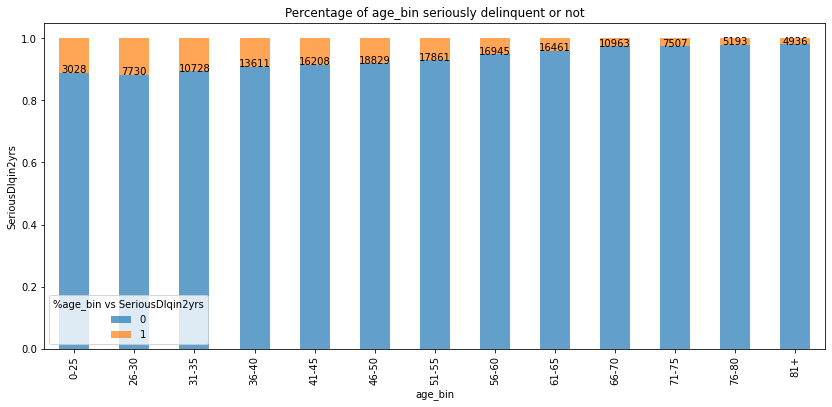

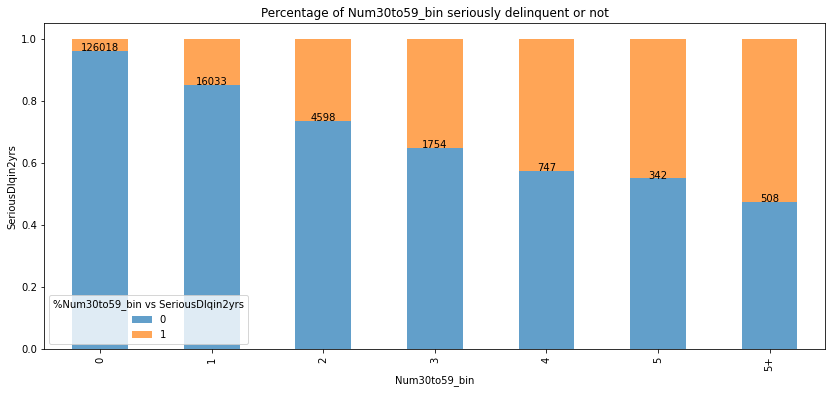

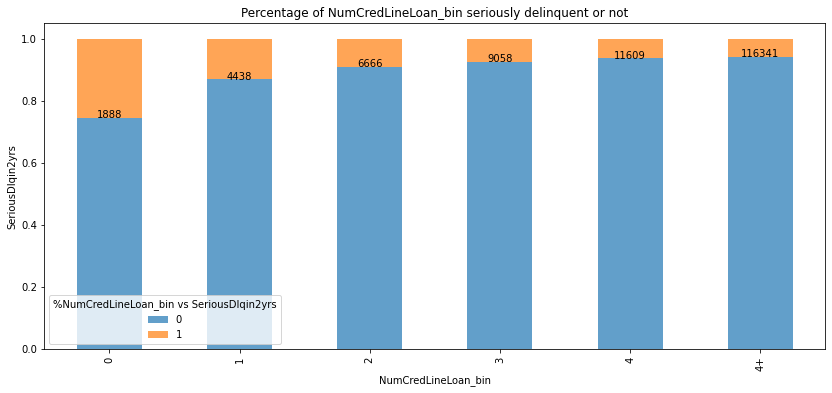

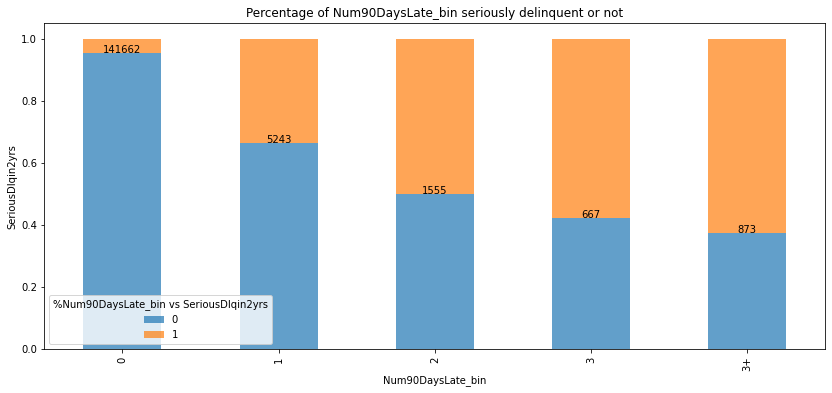

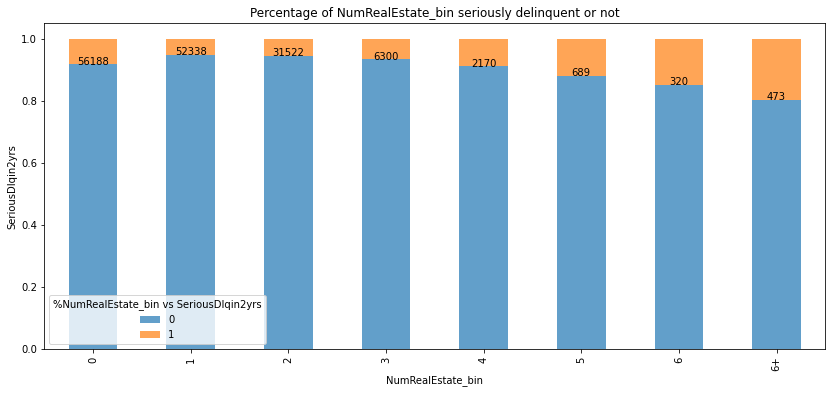

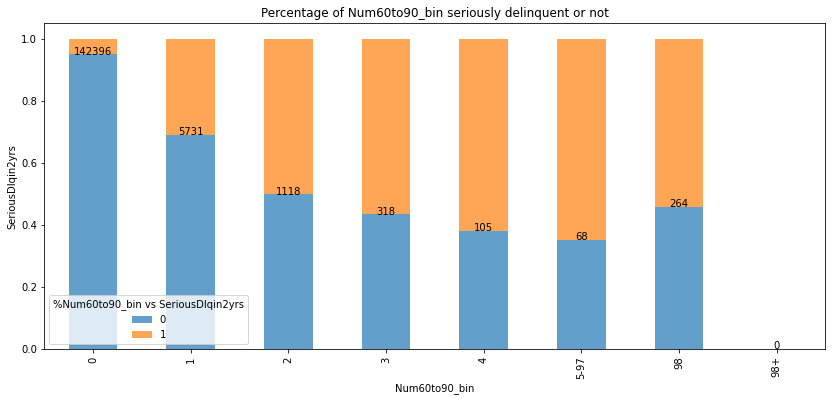

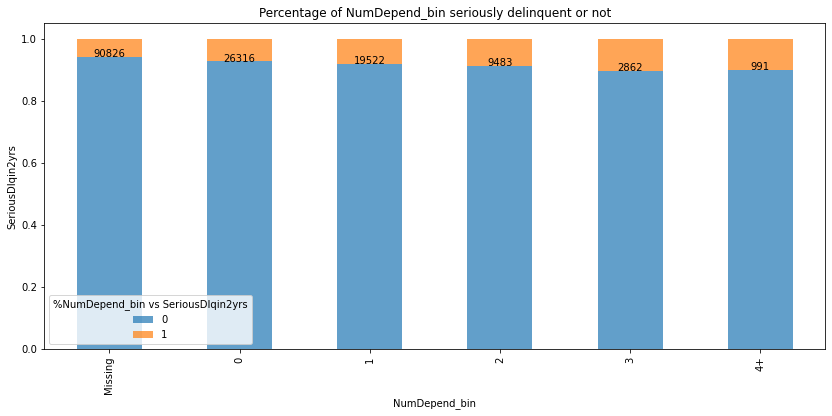

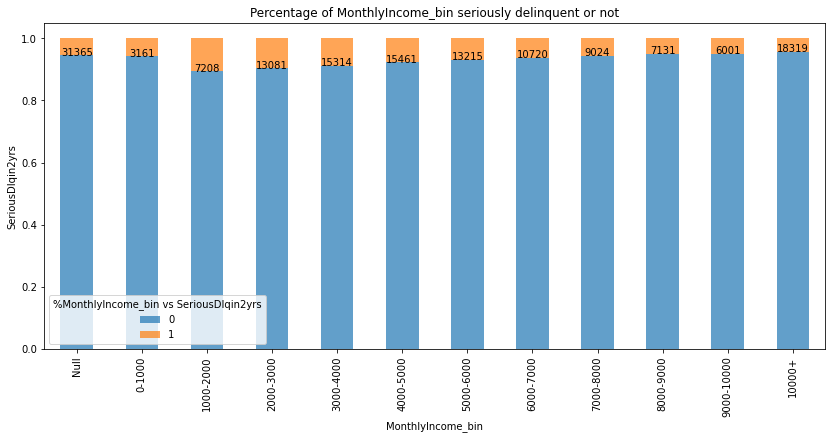

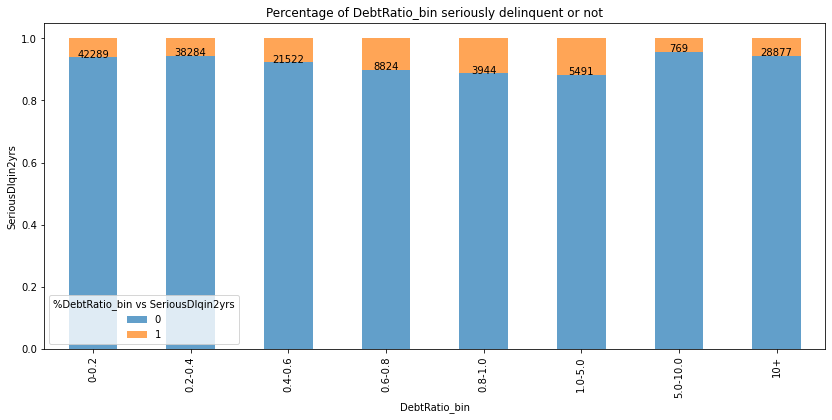

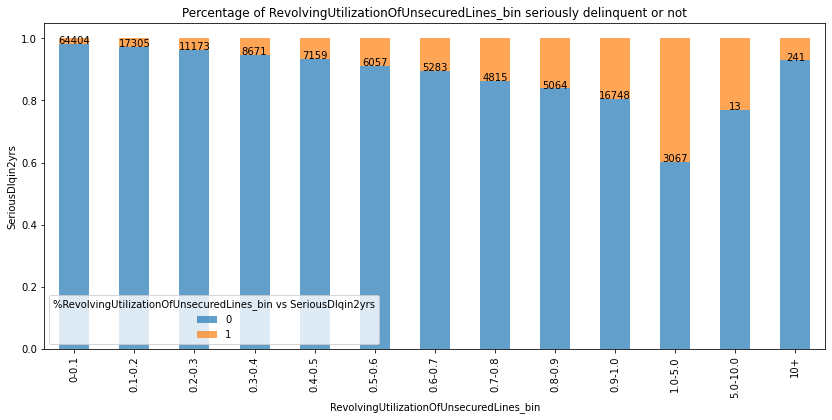

In [41]:
for var in bin_list:
    graph_vars(var)

In [42]:
%%html
<a id="section-2.2"></a>

Observations:

Age: Default rate tends to decrease with age. The youngest group may not have the highest default rate, for reasons similar to MonthlyIncome listed below.

Num30-59: A high number indicates a higher chance of default

NumCredLineLoan: Default rate decreases as NumCreditLineLoan increases

Num90DaysLate: Default rate increases sharply as Num90DaysLate increases. Whilst both variables relate to 90 days past due, the dependent variable SeriousDlqin2yrs is different in that the time period is restricted to the last two years, so those who have been 1 or more times 90 days past due delinquency are also flagged as SeriousDlqin2yrs if that default was within 2 years. Else it is a default prior to those 2 years.

NumRealEstate: Those unable to afford a mortgage or those who must have rent may have lower available money for debts, so 0 has a higher rate than 1. Those with 2+ real estate loans may find it hard to pay all commitments so the default rate increases thereafter.

Num60to90: Seems to have a special value at 98, and likely 96 too due to their abundancy and gap between lowers values. Trend seems to have increasing delinquency rate until the special values. 96 is grouped with lower values due to low population size, though this could be changed.

NumDepend: Doesn't seem to have as much affect as one might expect. Seems to have minimal effect on default rate

The lowest MonthlyIncome band (0-1000) has a lower default rate, despite having less funds to pay. Possible reasons for this include:

- They are loaned less money, making it easier to pay back

- They go through more thorough checks before being given the loan

- They are more careful with money as debt may have more impact on them

- They may have had fewer credit applications and so fewer chances to default

DebtRatio: between 0.6 and 1.0 have a higher default rate. Since $DebtRatio=\frac{debts and expenditure}{Monthly Income}$, there is a scatter plot below showing the relationship of Monthly Income and Debt Ratio. Set axis limits as desired as there are many inflated values that may make the graph hard to inteperet. It seems to suggest that those with the highest debt ratio, have little to no come. Possible caused by retirement, savings etc.

RevolvingUtilizationOfUnsecuredLines: Increased default rate with increased utilisation. Values greater than 1 may be obtained by reasons such as: Having a manually reduced credit limit, a non-updated credit limit, purchases made by exception given by the credit loaner, special payment plans etc.

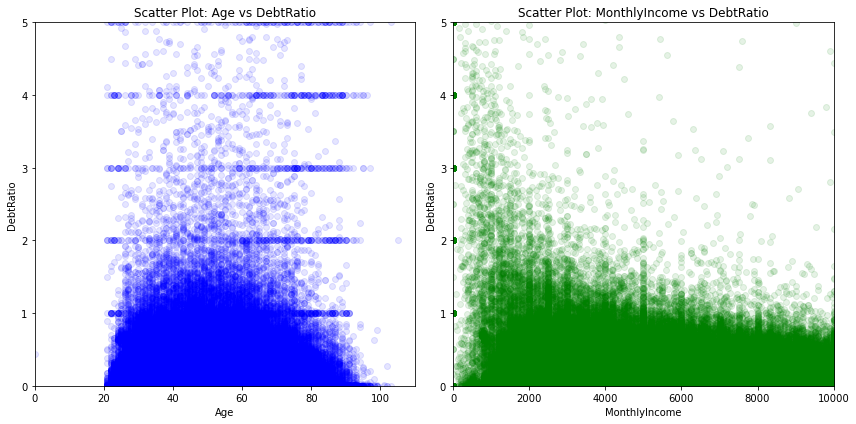

In [43]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for Age vs Column_B
ax[0].set_xlim(0,110)
ax[0].set_ylim(0,5)
ax[0].scatter(raw_credit_training_data['age'], raw_credit_training_data['DebtRatio'], color='blue', marker='o', alpha=0.1)
ax[0].set_title('Scatter Plot: Age vs DebtRatio')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('DebtRatio')

# Scatter plot for MonthlyIncome vs Column_B
ax[1].set_xlim(0,10000)
ax[1].set_ylim(0,5)
ax[1].scatter(raw_credit_training_data['MonthlyIncome'], raw_credit_training_data['DebtRatio'], color='green', marker='o', alpha=0.1)
ax[1].set_title('Scatter Plot: MonthlyIncome vs DebtRatio')
ax[1].set_xlabel('MonthlyIncome')
ax[1].set_ylabel('DebtRatio')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

So a higher DebtRatio correlates with those with little income. Age does not seem to have a visible impact on this.

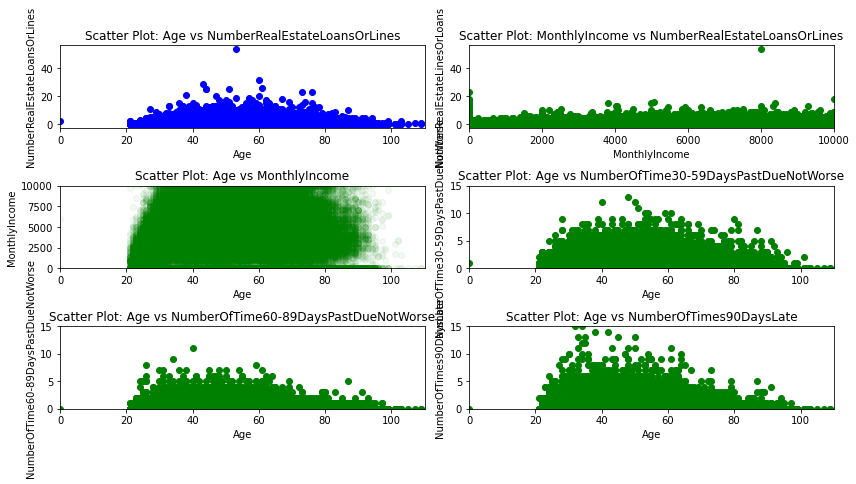

In [44]:
# Create a figure with subplots
fig, ax = plt.subplots(3, 2, figsize=(12, 6))

# Scatter plot for Age vs Column_B
ax[0,0].set_xlim(0,110)
ax[0,0].scatter(raw_credit_training_data['age'], raw_credit_training_data['NumberRealEstateLoansOrLines'], color='blue', marker='o')
ax[0,0].set_title('Scatter Plot: Age vs NumberRealEstateLoansOrLines')
ax[0,0].set_xlabel('Age')
ax[0,0].set_ylabel('NumberRealEstateLoansOrLines')

# Scatter plot for MonthlyIncome vs Column_B
ax[0,1].set_xlim(0,10000)
ax[0,1].scatter(raw_credit_training_data['MonthlyIncome'], raw_credit_training_data['NumberRealEstateLoansOrLines'], color='green', marker='o')
ax[0,1].set_title('Scatter Plot: MonthlyIncome vs NumberRealEstateLoansOrLines')
ax[0,1].set_xlabel('MonthlyIncome')
ax[0,1].set_ylabel('NumberRealEstateLinesOrLoans')

# Scatter plot for MonthlyIncome vs Column_B
ax[1,0].set_xlim(0,110)
ax[1,0].set_ylim(0,10000)
ax[1,0].scatter(raw_credit_training_data['age'], raw_credit_training_data['MonthlyIncome'], color='green', marker='o', alpha=0.05)
ax[1,0].set_title('Scatter Plot: Age vs MonthlyIncome')
ax[1,0].set_xlabel('Age')
ax[1,0].set_ylabel('MonthlyIncome')

# Scatter plot for MonthlyIncome vs Column_B
ax[1,1].set_xlim(0,110)
ax[1,1].set_ylim(0,15) #special values at 97 and 98
ax[1,1].scatter(raw_credit_training_data['age'], raw_credit_training_data['NumberOfTime30-59DaysPastDueNotWorse'], color='green', marker='o')
ax[1,1].set_title('Scatter Plot: Age vs NumberOfTime30-59DaysPastDueNotWorse')
ax[1,1].set_xlabel('Age')
ax[1,1].set_ylabel('NumberOfTime30-59DaysPastDueNotWorse')

# Scatter plot for MonthlyIncome vs Column_B
ax[2,0].set_xlim(0,110)
ax[2,0].set_ylim(0,15) #special values at 97 and 98
ax[2,0].scatter(raw_credit_training_data['age'], raw_credit_training_data['NumberOfTime60-89DaysPastDueNotWorse'], color='green', marker='o')
ax[2,0].set_title('Scatter Plot: Age vs NumberOfTime60-89DaysPastDueNotWorse')
ax[2,0].set_xlabel('Age')
ax[2,0].set_ylabel('NumberOfTime60-89DaysPastDueNotWorse')

# Scatter plot for MonthlyIncome vs Column_B
ax[2,1].set_xlim(0,110)
ax[2,1].set_ylim(0,15) #special values at 97 and 98
ax[2,1].scatter(raw_credit_training_data['age'], raw_credit_training_data['NumberOfTimes90DaysLate'], color='green', marker='o')
ax[2,1].set_title('Scatter Plot: Age vs NumberOfTimes90DaysLate')
ax[2,1].set_xlabel('Age')
ax[2,1].set_ylabel('NumberOfTimes90DaysLate')


# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

Text(0.5, 1.0, 'Age vs Number of Dependents')

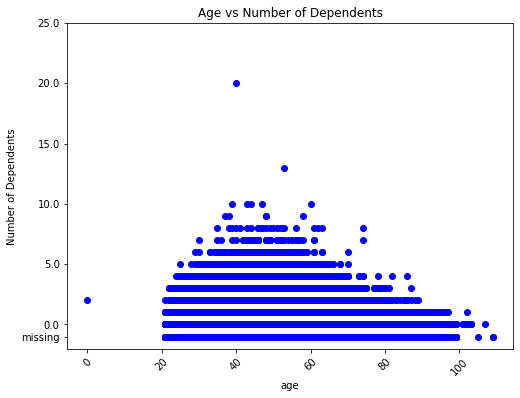

In [45]:
plt.figure(figsize=(8, 6))
plt.scatter(raw_credit_training_data['age'], raw_credit_training_data['NumberOfDependents'], color='blue')
plt.xticks(rotation=45)
# Adding labels and title

# Get the default y-axis ticks
default_yticks = plt.yticks()[0]

# Set y-axis ticks and labels
yticks = list(default_yticks)
yticks[0]=-1 # Modify the label for -1 as it corresponds to missing values.
#Replacing the first element of -5 with -1 as -5 is unused
# Change label of -1 to missing
yticklabels = ['missing' if tick == -1 else str(tick) for tick in yticks]
plt.xlabel('age')
plt.ylabel('Number of Dependents')
plt.yticks(yticks, yticklabels)
plt.title('Age vs Number of Dependents')

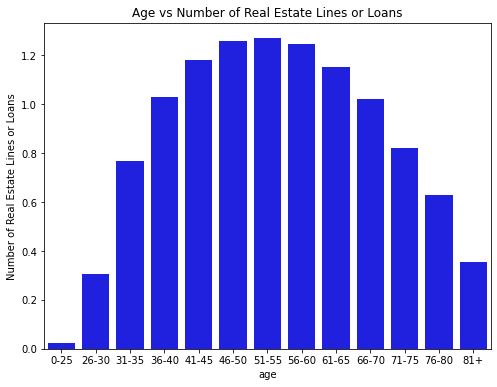

In [46]:
plt.figure(figsize=(8, 6))
mean_by_age = raw_credit_training_data.groupby('age_bin')['NumberRealEstateLoansOrLines'].mean().to_frame().reset_index()
#plt.bar(mean_by_age['age_bin'], mean_by_age['NumberRealEstateLoansOrLines'], color='blue')
sns.barplot(x='age_bin', y='NumberRealEstateLoansOrLines', data=mean_by_age, color='blue')
# Adding labels and title
plt.xlabel('age')
plt.ylabel('Number of Real Estate Lines or Loans')
plt.title('Age vs Number of Real Estate Lines or Loans')
plt.show()

Let's see what percentage of people have taken out a mortgage etc:

In [47]:
len(raw_credit_training_data[raw_credit_training_data['NumberRealEstateLoansOrLines']>0])/len(raw_credit_training_data['NumberRealEstateLoansOrLines'])

0.6254133333333334

The above value indicates that some affluence in the population.

In [48]:
%%html
<a id="section-3"></a>

### Calculating the Weight of Evidence (WoE) and Information Value (IV) for each variable

Calculating the IV can give evidence as to what the strong predictors of the dependent variable SeriousDlqin2yrs are.

Here, the WoE value describes how well a variable can separate defaulters from non-defaulters, or 'goods' from 'bads'.

In the model input, using the WoE of each bucket, instead of bucket itself, can yield better results, so let's calculate these values.

Note: Here the WoE values were calculated by using proportions on the entire training dataset, when, for validation purposes, it would have been better to calculate WoE by splitting the full training data set into train and validation datasets, then calculating WoE based on the proportion of events in the train dataset. After evaluating the model on the validation dataset, we may have a better understanding of how the final model will perform after being trained on the full training dataset.

In [49]:
#Create a checkpoint of the data processing ran so far
raw_credit_training_data_copy=raw_credit_training_data.copy()

  NumDepend_bin  NumDepend_bin Total  Events  Non-Events  % Events  \
0       Missing                90826    5274       85552      0.53   
1             0                26316    1935       24381      0.19   
2             1                19522    1584       17938      0.16   
3             2                 9483     837        8646      0.08   
4             3                 2862     297        2565      0.03   
5            4+                  991      99         892      0.01   

   % Non-Events  NumDepend_bin_WoE    IV  
0          0.61               2.79  0.24  
1          0.17               2.53 -0.05  
2          0.13               2.43 -0.07  
3          0.06               2.33 -0.05  
4          0.02               2.15 -0.02  
5          0.01               2.19 -0.01  


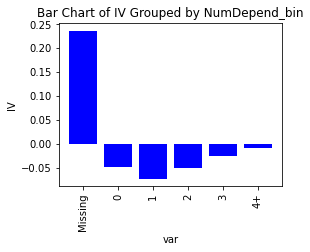

   MonthlyIncome_bin  MonthlyIncome_bin Total  Events  Non-Events  % Events  \
0               Null                    31365    1735       29630      0.17   
1             0-1000                     3161     181        2980      0.02   
2          1000-2000                     7208     767        6441      0.08   
3          2000-3000                    13081    1263       11818      0.13   
4          3000-4000                    15314    1349       13965      0.13   
5          4000-5000                    15461    1187       14274      0.12   
6          5000-6000                    13215     918       12297      0.09   
7          6000-7000                    10720     664       10056      0.07   
8          7000-8000                     9024     509        8515      0.05   
9          8000-9000                     7131     361        6770      0.04   
10        9000-10000                     6001     300        5701      0.03   
11            10000+                    18319     79

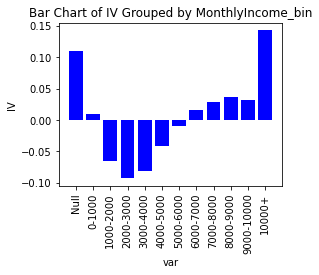

  DebtRatio_bin  DebtRatio_bin Total  Events  Non-Events  % Events  \
0         0-0.2                42289    2585       39704      0.26   
1       0.2-0.4                38284    2156       36128      0.22   
2       0.4-0.6                21522    1656       19866      0.17   
3       0.6-0.8                 8824     893        7931      0.09   
4       0.8-1.0                 3944     445        3499      0.04   
5       1.0-5.0                 5491     649        4842      0.06   
6      5.0-10.0                  769      33         736      0.00   
7           10+                28877    1609       27268      0.16   

   % Non-Events  DebtRatio_bin_WoE    IV  
0          0.28               2.73  0.07  
1          0.26               2.82  0.12  
2          0.14               2.48 -0.06  
3          0.06               2.18 -0.07  
4          0.02               2.06 -0.04  
5          0.03               2.01 -0.06  
6          0.01               3.09  0.01  
7          0.19          

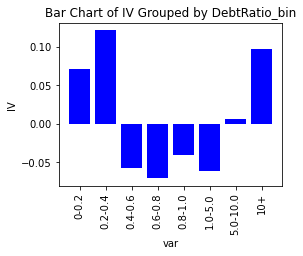

   RevolvingUtilizationOfUnsecuredLines_bin  \
0                                     0-0.1   
1                                   0.1-0.2   
2                                   0.2-0.3   
3                                   0.3-0.4   
4                                   0.4-0.5   
5                                   0.5-0.6   
6                                   0.6-0.7   
7                                   0.7-0.8   
8                                   0.8-0.9   
9                                   0.9-1.0   
10                                  1.0-5.0   
11                                 5.0-10.0   
12                                      10+   

    RevolvingUtilizationOfUnsecuredLines_bin Total  Events  Non-Events  \
0                                            64404    1166       63238   
1                                            17305     481       16824   
2                                            11173     414       10759   
3                                            

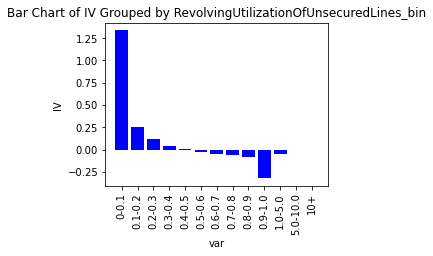

   age_bin  age_bin Total  Events  Non-Events  % Events  % Non-Events  \
0     0-25           3028     338        2690      0.03          0.02   
1    26-30           7730     906        6824      0.09          0.05   
2    31-35          10728    1147        9581      0.11          0.07   
3    36-40          13611    1243       12368      0.12          0.09   
4    41-45          16208    1385       14823      0.14          0.11   
5    46-50          18829    1508       17321      0.15          0.12   
6    51-55          17861    1278       16583      0.13          0.12   
7    56-60          16945     871       16074      0.09          0.11   
8    61-65          16461     660       15801      0.07          0.11   
9    66-70          10963     292       10671      0.03          0.08   
10   71-75           7507     191        7316      0.02          0.05   
11   76-80           5193     107        5086      0.01          0.04   
12     81+           4936     100        4836      

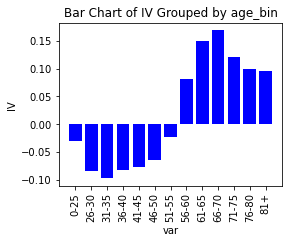

  Num30to59_bin  Num30to59_bin Total  Events  Non-Events  % Events  \
0             0               126018    5041      120977      0.50   
1             1                16033    2409       13624      0.24   
2             2                 4598    1219        3379      0.12   
3             3                 1754     618        1136      0.06   
4             4                  747     318         429      0.03   
5             5                  342     154         188      0.02   
6            5+                  508     267         241      0.03   

   % Non-Events  Num30to59_bin_WoE    IV  
0          0.86               3.18  1.15  
1          0.10               1.73 -0.25  
2          0.02               1.02 -0.10  
3          0.01               0.61 -0.03  
4          0.00               0.30 -0.01  
5          0.00               0.20 -0.00  
6          0.00              -0.10  0.00  


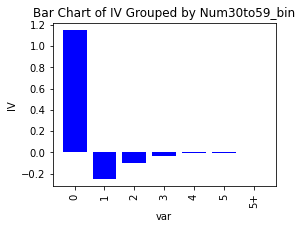

  NumCredLineLoan_bin  NumCredLineLoan_bin Total  Events  Non-Events  \
0                   0                       1888     484        1404   
1                   1                       4438     585        3853   
2                   2                       6666     609        6057   
3                   3                       9058     682        8376   
4                   4                      11609     743       10866   
5                  4+                     116341    6923      109418   

   % Events  % Non-Events  NumCredLineLoan_bin_WoE    IV  
0      0.05          0.01                     1.06 -0.04  
1      0.06          0.03                     1.88 -0.06  
2      0.06          0.04                     2.30 -0.04  
3      0.07          0.06                     2.51 -0.02  
4      0.07          0.08                     2.68  0.01  
5      0.69          0.78                     2.76  0.25  


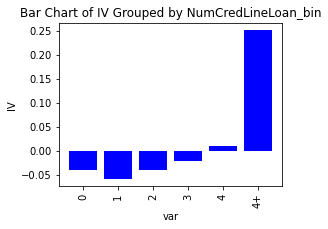

  Num90DaysLate_bin  Num90DaysLate_bin Total  Events  Non-Events  % Events  \
0                 0                   141662    6554      135108      0.65   
1                 1                     5243    1765        3478      0.18   
2                 2                     1555     776         779      0.08   
3                 3                      667     385         282      0.04   
4                3+                      873     546         327      0.05   

   % Non-Events  Num90DaysLate_bin_WoE    IV  
0          0.97                   3.03  0.94  
1          0.02                   0.68 -0.10  
2          0.01                   0.00 -0.00  
3          0.00                  -0.31  0.01  
4          0.00                  -0.51  0.03  


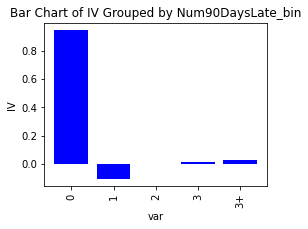

  NumRealEstate_bin  NumRealEstate_bin Total  Events  Non-Events  % Events  \
0                 0                    56188    4672       51516      0.47   
1                 1                    52338    2748       49590      0.27   
2                 2                    31522    1765       29757      0.18   
3                 3                     6300     422        5878      0.04   
4                 4                     2170     194        1976      0.02   
5                 5                      689      83         606      0.01   
6                 6                      320      48         272      0.00   
7                6+                      473      94         379      0.01   

   % Non-Events  NumRealEstate_bin_WoE    IV  
0          0.37                   2.40 -0.24  
1          0.35                   2.89  0.23  
2          0.21                   2.82  0.10  
3          0.04                   2.63 -0.00  
4          0.01                   2.32 -0.01  
5          0.00

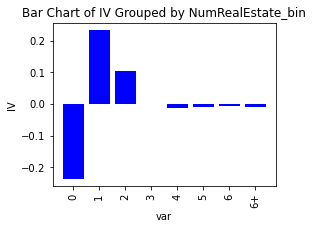

  Num60to90_bin  Num60to90_bin Total  Events  Non-Events  % Events  \
0             0               142396    7256      135140      0.72   
1             1                 5731    1777        3954      0.18   
2             2                 1118     561         557      0.06   
3             3                  318     180         138      0.02   
4             4                  105      65          40      0.01   
5          5-97                   68      44          24      0.00   
6            98                  264     143         121      0.01   
7           98+                    0       0           0      0.00   

   % Non-Events  Num60to90_bin_WoE    IV  
0          0.97               2.92  0.71  
1          0.03               0.80 -0.12  
2          0.00              -0.01  0.00  
3          0.00              -0.26  0.00  
4          0.00              -0.48  0.00  
5          0.00              -0.60  0.00  
6          0.00              -0.17  0.00  
7          0.00          

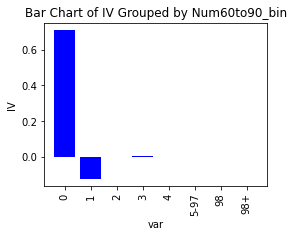

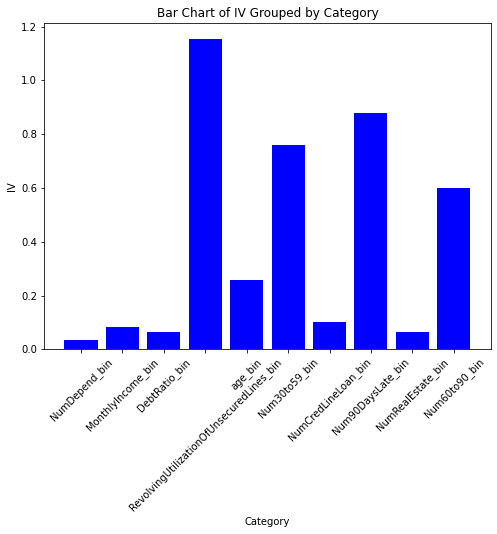

,var,Events,Non-Events,% Events,% Non-Events,WoE,IV
0,NumDepend_bin,10026.00,139974.00,1.00,1.00,14.43,0.03
1,MonthlyIncome_bin,10026.00,139974.00,1.00,1.00,31.92,0.08
2,DebtRatio_bin,10026.00,139974.00,1.00,1.00,20.21,0.07
3,RevolvingUtilizationOfUnsecuredLines_bin,10026.00,139974.00,1.00,1.00,29.83,1.16
4,age_bin,10026.00,139974.00,1.00,1.00,36.94,0.26
5,Num30to59_bin,10026.00,139974.00,1.00,1.00,6.93,0.76
6,NumCredLineLoan_bin,10026.00,139974.00,1.00,1.00,13.19,0.10
7,Num90DaysLate_bin,10026.00,139974.00,1.00,1.00,2.89,0.88
8,NumRealEstate_bin,10026.00,139974.00,1.00,1.00,18.17,0.07
9,Num60to90_bin,10026.00,139974.00,1.00,1.00,2.21,0.60


In [50]:
#Restore the data to the checkpoint. This helps ensures that raw_credit_training_data is not over-processed if the code is ran multiple times
raw_credit_training_data=raw_credit_training_data_copy

#List of variables that we will create WoE values for. This is all of them except for the index and dependent variable. (id and SeriousDlqin2yrs)
WoE_columns=['NumDepend_bin', 'MonthlyIncome_bin',
       'DebtRatio_bin', 'RevolvingUtilizationOfUnsecuredLines_bin', 'age_bin',
       'Num30to59_bin', 'NumCredLineLoan_bin', 'Num90DaysLate_bin',
       'NumRealEstate_bin', 'Num60to90_bin']

#initialise table of summed WoE and IV values
sum_table = pd.DataFrame()

#Calculate counts and %s of 'events', or defaults, and 'non-events' or non-defaulters.
#Use the adjusted WoE, by adding 0.5, or taking the maximum compared with 0.5, where appropriate.
#This avoids potential division by 0 scenarios.
def create_woe_table(var, printing=True):
    WoE_table=raw_credit_training_data[['SeriousDlqin2yrs',var]].groupby(var)['SeriousDlqin2yrs'].agg(['count', 'sum'])
    WoE_table.rename(columns={'count': f'{var} Total', 'sum': 'Events'}, inplace=True)
    WoE_table['Non-Events'] = WoE_table[f'{var} Total'] - WoE_table['Events']
    WoE_table['% Events'] = (np.maximum(WoE_table['Events'],0.5)) / WoE_table['Events'].sum()
    WoE_table['% Non-Events'] = (np.maximum(WoE_table['Non-Events'],0.5)) / WoE_table['Non-Events'].sum()
    WoE_table[f'{var}_WoE']=np.log((WoE_table['Non-Events']+0.5)/(WoE_table['Events']+0.5))
    WoE_table['IV']=(WoE_table['% Non-Events']-WoE_table['% Events'])*WoE_table[f'{var}_WoE']
    WoE_table=WoE_table.reset_index()
    #Sum each column, with the summed WoE values being the IV value
    sum_row = WoE_table[[f'{var} Total', 'Events', 'Non-Events', '% Events', '% Non-Events', f'{var}_WoE', 'IV']].sum()
    sum_row = sum_row.rename({f'{var} Total': "var", f'{var}_WoE': "WoE"})
    sum_row=pd.DataFrame(sum_row).T
    sum_row['var'] = var
    if printing==True:
        print(WoE_table)
    return WoE_table, sum_row

#print table of WoE values for each variable.
#Merge WoE values onto main dataset, corresponding to the appropriate bins
#Afterwards, print the summed table, containing the IV values for inspection.
for var in WoE_columns:
    WoE_table, sum_row=create_woe_table(var)
    ###
    plt.figure(figsize=(4, 3))
    plt.bar(WoE_table[var], WoE_table['IV'], color='blue')
    plt.xticks(rotation=90)
    # Adding labels and title
    plt.xlabel('var')
    plt.ylabel('IV')
    plt.title(f'Bar Chart of IV Grouped by {var}')

    # Show the plot
    plt.show()
    ###
    if sum_table.empty:
        # Add the first row
        sum_table = sum_row
    else:
        # If it's not empty, append the table to the last table
        sum_table = pd.concat([sum_table,sum_row], ignore_index=True)
    raw_credit_training_data=pd.merge(raw_credit_training_data, WoE_table[[var,f'{var}_WoE']], on=var, how='left')

#graph the IV values by variable as well
plt.figure(figsize=(8, 6))
plt.bar(sum_table['var'], sum_table['IV'], color='blue')
plt.xticks(rotation=45)
# Adding labels and title
plt.xlabel('Category')
plt.ylabel('IV')
plt.title('Bar Chart of IV Grouped by Category')

# Show the plot
plt.show()
sum_table

According to https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#what_is_information_value:

A total IV value of:

0.3-0.5: Strong predictive power

\>0.5: suspicious predictive power

The above has: RevolvingUtilizationOfUnsecuredLines_bin, Num30to59_bin, Num90DaysLate_bin, Num60to90_bin as the strong predictors. Using the above criteria one may describe them as 'suspiciously' strong, but perhaps here it is reasonable for the Num_X_DaysLate variables due to their high correlation with default.

As for RevolvingUtilizationOfUnsecuredLines, perhaps the high IV value indicates that the bucketing could be done better or that  some understanding of the data is missing.

Age may also be considered to have a reasonable predictive power.

In fact, more attention to the bucketing for every variable is likely needed. One suggestion is to create the bins such that WoE increases/decreases monotonically from one bin to the next. According to the following pdf, http://www.m-hikari.com/ams/ams-2014/ams-65-68-2014/zengAMS65-68-2014.pdf, some common binning algorithms are: equal-width binning, equal-size binning, optima binning and Multi-Interval Discretization

In [51]:
#List of the WoE columns for ease of use
WoE_vars=['NumDepend_bin_WoE', 'MonthlyIncome_bin_WoE',
       'DebtRatio_bin_WoE', 'RevolvingUtilizationOfUnsecuredLines_bin_WoE', 'age_bin_WoE',
       'Num30to59_bin_WoE', 'NumCredLineLoan_bin_WoE', 'Num90DaysLate_bin_WoE',
       'NumRealEstate_bin_WoE', 'Num60to90_bin_WoE']
#List of the high value IV WoE columns - perhaps age should not be included here
WoE_vars_high=['RevolvingUtilizationOfUnsecuredLines_bin_WoE','Num30to59_bin_WoE','Num90DaysLate_bin_WoE','Num60to90_bin_WoE','age_bin_WoE']
WoE_vars_highest=['Num90DaysLate_bin_WoE','Num30to59_bin_WoE','Num60to90_bin_WoE','RevolvingUtilizationOfUnsecuredLines_bin_WoE']
top_two_WoE_vars=['Num90DaysLate_bin_WoE','RevolvingUtilizationOfUnsecuredLines_bin_WoE']

In [52]:
%%html
<a id="section-4"></a>

### Section 4: Model building

Here will list some different inputs to run with the various models.

The models to run will be logistic regression and XGBoost.

These have been chosen as they are easy to intepret and can still achieve good results if implemented properly.

The order of operations will be:

(0) If needed, one-hot encode the variables

(1) Split into train/test sets

(2) Create models

(3) Gather data on the results of the models

## How to use the models:

Create an input dataset with columns corresponding to the input variables

Create a list corresponding to the names of those columns in the input dataset

Run the below definition `model_run(input_dataset)`

In [53]:
%%html
<a id="section-4.1"></a>

#### 4.1 Model input

In [54]:
#List of combinations of variables to try in our input dataset
all_woe_vars=WoE_vars
high_pred_woe_vars=WoE_vars_high
highest_woe=WoE_vars_highest
binned_vars=bin_list
top_two_WoE_vars

['Num90DaysLate_bin_WoE', 'RevolvingUtilizationOfUnsecuredLines_bin_WoE']

The below definition takes our input dataset. If needed it will one-hot encode the variables.

Then it will split the data into train and test datasets, as well as record the number of defaults and non-defaults in the training set. These values will be used to weight the XGB model later on.

In [55]:
def prepare_input_data(input_vars, one_hot_encode=False):
    input_data=raw_credit_training_data[input_vars]
    if one_hot_encode==True:
        input_data=pd.get_dummies(raw_credit_training_data[input_vars], prefix=bin_list)
    y_dependent=raw_credit_training_data['SeriousDlqin2yrs']
    X_train, X_val, y_train, y_val = train_test_split(input_data, y_dependent, test_size=0.2, random_state=16)
    
    #Get the number of defaults in the training set for weighting/balancing purposes
    X_def=y_train.sum()#Num defaults
    X_not_def=len(y_train)-y_train.sum()#Num Non-defaults
    return X_train, X_val, y_train, y_val, X_def, X_not_def

The below definition defines the models. Here We use logistic regression and xgboost, both weighted and non-weighted according to the proportion of defaults in the training dataset.

In [56]:
def create_models(X_train, y_train, X_def, X_not_def):
    #Logistic Regression
    #Balanced
    LogReg_bal=LogisticRegression(max_iter=1000, class_weight='balanced')
    LogReg_bal.fit(X_train, y_train)

    #Not balanced
    LogReg=LogisticRegression(max_iter=1000)
    LogReg.fit(X_train, y_train)

    #XGBoost
    #Balanced
    xgb_bal = XGBClassifier(objective='binary:logistic', scale_pos_weight=X_not_def/X_def)
    xgb_bal.fit(X_train, y_train)

    #Not balanced
    xgb= XGBClassifier(objective='binary:logistic')
    xgb.fit(X_train, y_train)
    return LogReg_bal, LogReg, xgb_bal, xgb

In [57]:
model_names=['LogReg_bal','LogReg','xgb_bal','xgb']

The below definition creates a dataframe with a column for each model defined. Then, it evaluates the validation data, predicting if that customer will default or not, given the input data for that model.

In [58]:
#create a table with the actual vs predicted values of each model
def create_results(model_list, model_names, y_val, X_val):
    #Perform sanity check so that models and names of models are the same
    if len(model_list)!=len(model_names):
        print("Please change the model_list/model_names variable accordingly")
    results=pd.DataFrame({'id': y_val.reset_index()['index'], 'SeriousDlqin2yrs':y_val.reset_index()['SeriousDlqin2yrs']})
    for model in range(len(model_list)):
        results[model_names[model]]=model_list[model].predict(X_val)
    return results

The below definition records some statistics about the data, such as number of defaults in the dataset, number of true positive predictions by each model, etc.

In [59]:
#create a dataframe with information on model performance such as accuracy, precision etc
def result_summary(results_df,columns=model_names):
    #Statistics to calculate
    stat_names=['defaults','non_defaults', 'default ratio','non_default ratio', \
                'pred_defaults','pred_non_defaults',\
                'true_positives','false_positives','true_negatives','false_negatives',\
               'accuracy','precision', 'default_precision']
    result_df=pd.DataFrame({'Statname': stat_names})
    results_df_len=len(results_df)
    #Record statistics about the SeriousDlqin2yrs column
    defaults=0
    non_defaults=0
    for value in results_df['SeriousDlqin2yrs']:
        if value == 1:
            defaults += 1
        elif value==0:
            non_defaults+=1
    #Record statistics about the model predictions compared to the dependent variable SeriousDlqin2yrs
    for model in model_names:
        pred_defaults=0
        pred_non_defaults=0
        true_positives=0
        false_positives=0
        true_negatives=0
        false_negatives=0

        for value in results_df[model]:
            if value == 1:
                pred_defaults += 1
            elif value == 0:
                pred_non_defaults+=1
        for index, row in results_df[['SeriousDlqin2yrs',model]].iterrows():
            if row['SeriousDlqin2yrs'] == 1 and row[model] == 1:
                true_positives += 1
            elif row['SeriousDlqin2yrs'] == 0 and row[model] == 1:
                false_positives += 1
            elif row['SeriousDlqin2yrs'] == 0 and row[model] == 0:
                true_negatives += 1
            elif row['SeriousDlqin2yrs'] == 1 and row[model] == 0:
                false_negatives += 1
                
        #Create dataframe with summary of statistics calculated
        stat_df=[defaults,non_defaults, 100*defaults/results_df_len, 100*non_defaults/results_df_len, \
                pred_defaults,pred_non_defaults,\
                true_positives,false_positives,true_negatives,false_negatives,\
                100*(true_positives+true_negatives)/results_df_len, 100*true_positives/(true_positives+false_positives),\
                100*true_positives/defaults]
        result_df[model]=stat_df
    
    return result_df

In [60]:
#Create definition that combines the above steps, so that input variables produce models and a summary table
def model_run(input_data,one_hot_encode=False):
    X_train, X_val, y_train, y_val, X_def, X_not_def=prepare_input_data(input_data,one_hot_encode=one_hot_encode)
    LogReg_bal, LogReg, xgb_bal, xgb=create_models(X_train, y_train, X_def, X_not_def)
    model_list=[LogReg_bal, LogReg, xgb_bal, xgb]
    model_names=['LogReg_bal', 'LogReg', 'xgb_bal', 'xgb']
    summary=result_summary(create_results(model_list,model_names,y_val=y_val, X_val=X_val),columns=model_names)
    #print(summary, model_list, model_names, X_val)
    return summary, model_list, model_names, X_val, y_val

In [61]:
%%html
<a id="section-4.3"></a>

## Model results:

Obtain summary results for the input datasets listed above in 4.1.

In [62]:
# #run model using all the woe variables
summary_all, model_list_all, model_names_all, X_val_all, y_val_all=model_run(all_woe_vars)
#run model using the high predicting woe variables
summary_high_pred, model_list_high_pred, model_names_high_pred, X_val_high_pred, y_val_high_pred=model_run(high_pred_woe_vars)
#run model using only the highest woe variables
summary_highest, model_list_highest, model_names_highest, X_val_highest, y_val_highest=model_run(highest_woe)
#run model using only the top two woe variables
summary_top2, model_list_top2, model_names_top2, X_val_top2, y_val_top2=model_run(top_two_WoE_vars)
#run model not using any woe values and using the one-hot encoding of the variable bins
summary_binned, model_list_binned,model_names_binned, X_val_binned, y_val_binned=model_run(binned_vars, one_hot_encode=True)

Viewing some of the produced tables below:

In [63]:
summary_all

,Statname,LogReg_bal,LogReg,xgb_bal,xgb
0,defaults,2003.00,2003.00,2003.00,2003.00
1,non_defaults,27997.00,27997.00,27997.00,27997.00
2,default ratio,6.68,6.68,6.68,6.68
3,non_default ratio,93.32,93.32,93.32,93.32
4,pred_defaults,6610.00,633.00,6531.00,751.00
5,pred_non_defaults,23390.00,29367.00,23469.00,29249.00
6,true_positives,1474.00,391.00,1437.00,416.00
7,false_positives,5136.00,242.00,5094.00,335.00
8,true_negatives,22861.00,27755.00,22903.00,27662.00
9,false_negatives,529.00,1612.00,566.00,1587.00


In [64]:
summary_binned

,Statname,LogReg_bal,LogReg,xgb_bal,xgb
0,defaults,2003.00,2003.00,2003.00,2003.00
1,non_defaults,27997.00,27997.00,27997.00,27997.00
2,default ratio,6.68,6.68,6.68,6.68
3,non_default ratio,93.32,93.32,93.32,93.32
4,pred_defaults,6637.00,676.00,6395.00,707.00
5,pred_non_defaults,23363.00,29324.00,23605.00,29293.00
6,true_positives,1483.00,401.00,1449.00,396.00
7,false_positives,5154.00,275.00,4946.00,311.00
8,true_negatives,22843.00,27722.00,23051.00,27686.00
9,false_negatives,520.00,1602.00,554.00,1607.00


Let's look at the ROC and AUC curves:

With more time, the next step would be to adjust the threshold for predicting a default or not, to optimise certain business criteria such as true positive rate, true negative rate etc.

In [65]:
def roc_auc_plot(model_list, model_names, X_val, y_val, suffix=''):
    plt.figure(figsize=(8, 6))
    for model in range(len(model_list)):
        y_pred_proba = model_list[model].predict_proba(X_val)[::,1]
        fpr, tpr, thresholds = roc_curve(y_val,  y_pred_proba)
        auc = roc_auc_score(y_val, y_pred_proba)

        #create ROC curve
        plt.plot(fpr,tpr,label=f'{model_names[model]} AUC='+str(auc))
    plt.plot([0, 1], [0, 1], 'k--', label='y=x line')
    plt.title(f'ROC and AUC for models {suffix}')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

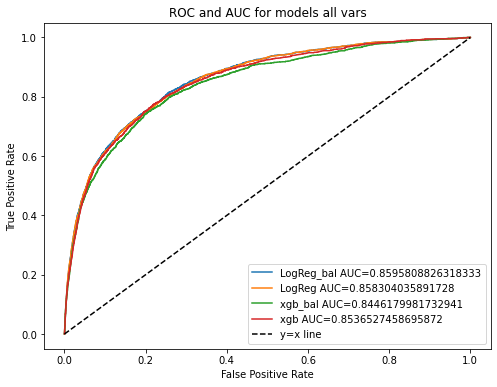

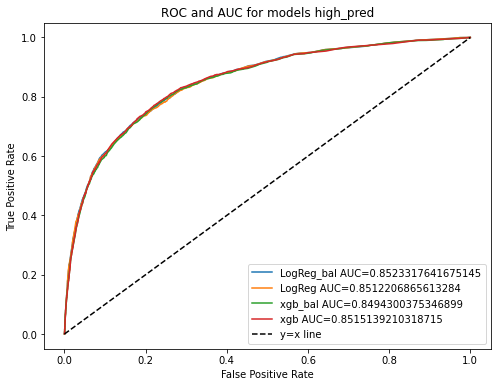

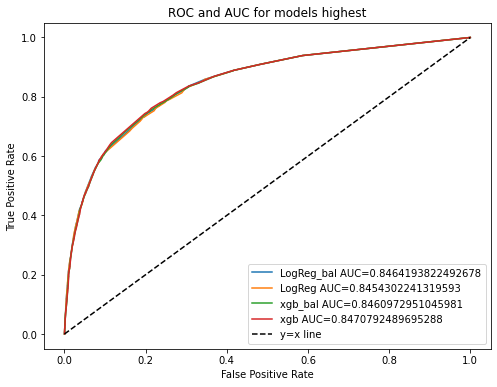

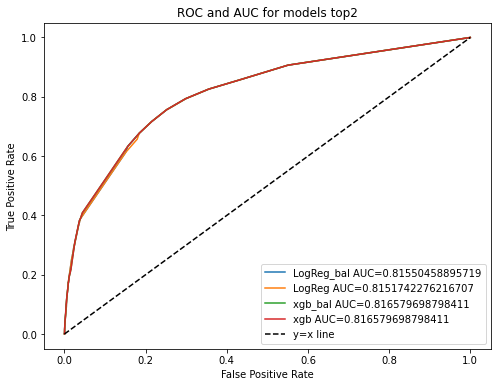

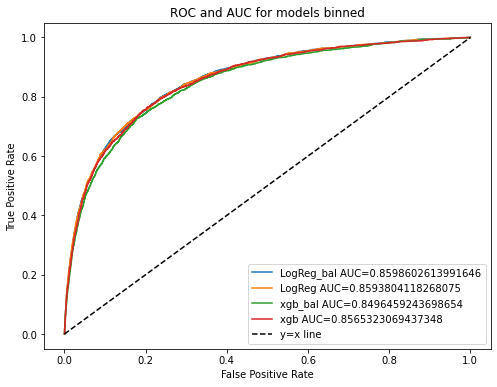

In [66]:
#View plots by input
roc_auc_plot(model_list_all,model_names_all, X_val=X_val_all, y_val=y_val_all,suffix='all vars')
roc_auc_plot(model_list_high_pred,model_names_high_pred, X_val=X_val_high_pred,y_val=y_val_high_pred,suffix='high_pred')
roc_auc_plot(model_list_highest,model_names_highest, X_val=X_val_highest,y_val=y_val_highest,suffix='highest')
roc_auc_plot(model_list_top2,model_names_top2, X_val=X_val_top2,y_val=y_val_top2,suffix='top2')
roc_auc_plot(model_list_binned,model_names_binned, X_val=X_val_binned,y_val=y_val_binned,suffix='binned')

Use the below to plot them separately

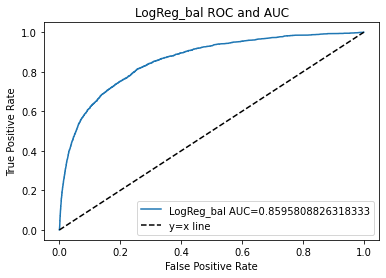

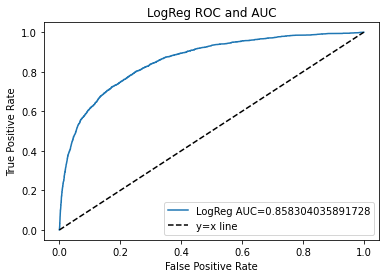

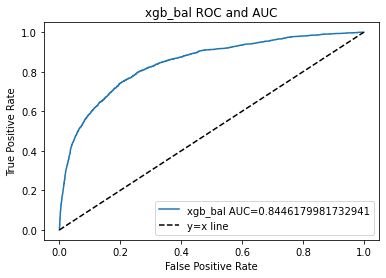

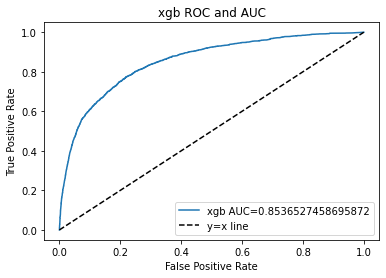

In [67]:
def roc_auc_plot_separate(model_list, model_names, X_val, y_val):
    for model in range(len(model_list)):
        #plt.figure(figsize=(4, 3))
        y_pred_proba = model_list[model].predict_proba(X_val)[::,1]
        fpr, tpr, thresholds = roc_curve(y_val,  y_pred_proba)
        auc = roc_auc_score(y_val, y_pred_proba)

        #create ROC curve
        plt.plot(fpr,tpr,label=f'{model_names[model]} AUC='+str(auc))
        plt.plot([0, 1], [0, 1], 'k--', label='y=x line')
        plt.title(f'{model_names[model]} ROC and AUC')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc=4)
        plt.show()
roc_auc_plot_separate(model_list_all,model_names_all,X_val_all,y_val_all)

The below cell will plot all the curves on one graph

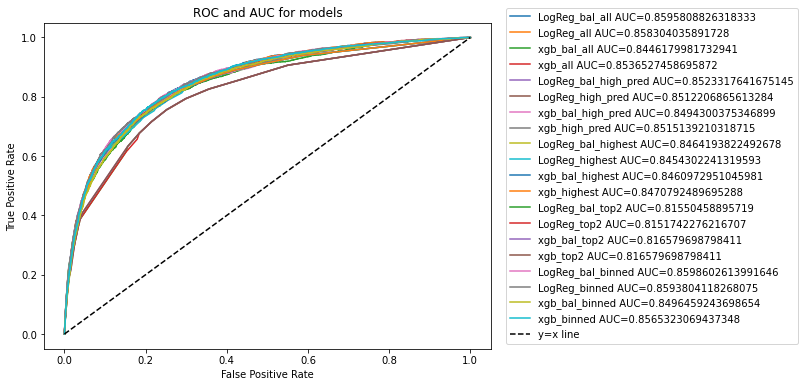

In [68]:
#All in one
plt.figure(figsize=(8, 6))
for model in range(len(model_list_all)):
    y_pred_proba = model_list_all[model].predict_proba(X_val_all)[::,1]
    fpr, tpr, thresholds = roc_curve(y_val_all,  y_pred_proba)
    auc = roc_auc_score(y_val_all, y_pred_proba)
    #create ROC curve
    plt.plot(fpr,tpr,label=f'{model_names_all[model]}_all AUC='+str(auc))

for model in range(len(model_list_high_pred)):
    y_pred_proba = model_list_high_pred[model].predict_proba(X_val_high_pred)[::,1]
    fpr, tpr, thresholds = roc_curve(y_val_high_pred,  y_pred_proba)
    auc = roc_auc_score(y_val_high_pred, y_pred_proba)
    #create ROC curve
    plt.plot(fpr,tpr,label=f'{model_names_high_pred[model]}_high_pred AUC='+str(auc))
    
for model in range(len(model_list_highest)):
    y_pred_proba = model_list_highest[model].predict_proba(X_val_highest)[::,1]
    fpr, tpr, thresholds = roc_curve(y_val_highest,  y_pred_proba)
    auc = roc_auc_score(y_val_highest, y_pred_proba)
    #create ROC curve
    plt.plot(fpr,tpr,label=f'{model_names_highest[model]}_highest AUC='+str(auc))
    
for model in range(len(model_list_top2)):
    y_pred_proba = model_list_top2[model].predict_proba(X_val_top2)[::,1]
    fpr, tpr, thresholds = roc_curve(y_val_top2,  y_pred_proba)
    auc = roc_auc_score(y_val_top2, y_pred_proba)
    #create ROC curve
    plt.plot(fpr,tpr,label=f'{model_names_top2[model]}_top2 AUC='+str(auc))
    
for model in range(len(model_list_binned)):
    y_pred_proba = model_list_binned[model].predict_proba(X_val_binned)[::,1]
    fpr, tpr, thresholds = roc_curve(y_val_binned,  y_pred_proba)
    auc = roc_auc_score(y_val_binned, y_pred_proba)
    #create ROC curve
    plt.plot(fpr,tpr,label=f'{model_names_binned[model]}_binned AUC='+str(auc))


plt.plot([0, 1], [0, 1], 'k--', label='y=x line')
plt.title('ROC and AUC for models')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4, bbox_to_anchor=(1.7, 0))
plt.show()

For the default threshold of 0.5, we see that most of the models give around the same curve, with the models using the fewest predictors as the weakest.

The best performing model was the LogisticRegression (balanced) model using all the input variables as WoE values. Very closely tied is the one-hot-encoded data from using all the input variables.

Let's now have a look at the strength of variables in the balanced logistic regression and xgboost models, trained using all the WoE variables:

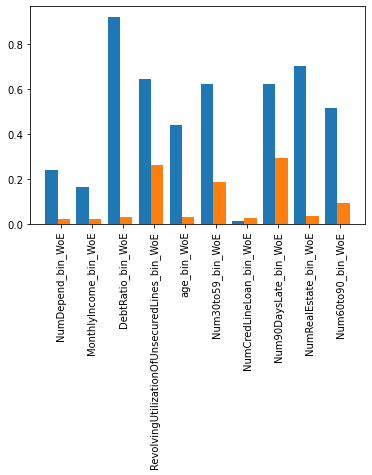

In [69]:
#comparing strength of predictors of the all_woe variable model, for balanced LogisticRegression and XGB
labels=X_val_all.columns.tolist()
indices = np.arange(len(labels))
bar_width = 0.2
plt.bar(indices-bar_width,abs(model_list_all[0].coef_[0]), width=bar_width*2)
plt.bar(indices+bar_width,model_list_all[2].feature_importances_, width=bar_width*2)
plt.xticks(rotation=90)
plt.xticks(indices + bar_width / 2, labels)
plt.show()

Predictive features of regression: DebtRatio, RevolvingUtilizationOfUnsecuredLines, #RealEstate, NumX-YDaysLate, age

Preditive features of XGB: RevolvingUtilizationOfUnsecuredLines, Num30-59DaysLateNotWorse, Num90DaysLate

LogisticRegression seems to have more actionable predictors , such as debt ratio and utilisation.

In [70]:
%%html
<a id="section-5"></a>

## Analysis of Model results

Running the three model inputs, we see that using all the WoE variables as inputs gives the most true positives

If a model predicts a default, there will be no profit or loss from that customer.
If a model predicts no default, the result will either be profit or loss.

If we assume the following:
- profit margin p (percent)
- average profit c
- only considering initial sale
- ignoring that fraud default generally has higher balance

then you need 1/p successful sales to break even.
Total profit will then be: $\sum Profit = c\times (True Negatives \times p - False Negatives)$

It is mentioned above in the AUC graphs that we should try changing the acceptance threshold to see how it affects the true postives etc. Results obtained with those thresholds can be tested in the above profit formula to test which threshold should be adopted.

Other business scenarios/assumptions:

People who are late and don't default give more profit due to interest and fees

Different expected profit separated by MonthlyIncome or other variable - the confusion matrix will differ depending on what category of people you are looking at.

Expected value of continued purchases. Assume a defaulter cannot try another purchase

An accepted person may default if they continue long enough, affecting the profit

Notes to add:

Could add a worse status variable to the input

Could identify true positive rate etc by demograph e.g. age, monthly income, to see if we are targeting the desired audience correctly

### Viewing all validation results

In [71]:
summary_binned

,Statname,LogReg_bal,LogReg,xgb_bal,xgb
0,defaults,2003.00,2003.00,2003.00,2003.00
1,non_defaults,27997.00,27997.00,27997.00,27997.00
2,default ratio,6.68,6.68,6.68,6.68
3,non_default ratio,93.32,93.32,93.32,93.32
4,pred_defaults,6637.00,676.00,6395.00,707.00
5,pred_non_defaults,23363.00,29324.00,23605.00,29293.00
6,true_positives,1483.00,401.00,1449.00,396.00
7,false_positives,5154.00,275.00,4946.00,311.00
8,true_negatives,22843.00,27722.00,23051.00,27686.00
9,false_negatives,520.00,1602.00,554.00,1607.00


In [72]:
summary_all

,Statname,LogReg_bal,LogReg,xgb_bal,xgb
0,defaults,2003.00,2003.00,2003.00,2003.00
1,non_defaults,27997.00,27997.00,27997.00,27997.00
2,default ratio,6.68,6.68,6.68,6.68
3,non_default ratio,93.32,93.32,93.32,93.32
4,pred_defaults,6610.00,633.00,6531.00,751.00
5,pred_non_defaults,23390.00,29367.00,23469.00,29249.00
6,true_positives,1474.00,391.00,1437.00,416.00
7,false_positives,5136.00,242.00,5094.00,335.00
8,true_negatives,22861.00,27755.00,22903.00,27662.00
9,false_negatives,529.00,1612.00,566.00,1587.00


In [73]:
summary_highest

,Statname,LogReg_bal,LogReg,xgb_bal,xgb
0,defaults,2003.00,2003.00,2003.00,2003.00
1,non_defaults,27997.00,27997.00,27997.00,27997.00
2,default ratio,6.68,6.68,6.68,6.68
3,non_default ratio,93.32,93.32,93.32,93.32
4,pred_defaults,7044.00,625.00,8356.00,606.00
5,pred_non_defaults,22956.00,29375.00,21644.00,29394.00
6,true_positives,1471.00,382.00,1562.00,342.00
7,false_positives,5573.00,243.00,6794.00,264.00
8,true_negatives,22424.00,27754.00,21203.00,27733.00
9,false_negatives,532.00,1621.00,441.00,1661.00


In [74]:
summary_high_pred

,Statname,LogReg_bal,LogReg,xgb_bal,xgb
0,defaults,2003.00,2003.00,2003.00,2003.00
1,non_defaults,27997.00,27997.00,27997.00,27997.00
2,default ratio,6.68,6.68,6.68,6.68
3,non_default ratio,93.32,93.32,93.32,93.32
4,pred_defaults,6720.00,607.00,7493.00,604.00
5,pred_non_defaults,23280.00,29393.00,22507.00,29396.00
6,true_positives,1466.00,379.00,1519.00,345.00
7,false_positives,5254.00,228.00,5974.00,259.00
8,true_negatives,22743.00,27769.00,22023.00,27738.00
9,false_negatives,537.00,1624.00,484.00,1658.00


In [75]:
summary_top2

,Statname,LogReg_bal,LogReg,xgb_bal,xgb
0,defaults,2003.00,2003.00,2003.00,2003.00
1,non_defaults,27997.00,27997.00,27997.00,27997.00
2,default ratio,6.68,6.68,6.68,6.68
3,non_default ratio,93.32,93.32,93.32,93.32
4,pred_defaults,7450.00,573.00,8578.00,605.00
5,pred_non_defaults,22550.00,29427.00,21422.00,29395.00
6,true_positives,1435.00,330.00,1516.00,342.00
7,false_positives,6015.00,243.00,7062.00,263.00
8,true_negatives,21982.00,27754.00,20935.00,27734.00
9,false_negatives,568.00,1673.00,487.00,1661.00


In [76]:
print(model_list_highest[3].feature_importances_)
X_val_highest.head()

[0.49896246 0.13936551 0.10292877 0.25874323]


,Num90DaysLate_bin_WoE,Num30to59_bin_WoE,Num60to90_bin_WoE,RevolvingUtilizationOfUnsecuredLines_bin_WoE
111334,3.03,3.18,2.92,3.55
37281,3.03,3.18,2.92,1.42
146403,3.03,3.18,2.92,3.99
148722,3.03,3.18,0.80,0.42
123815,3.03,3.18,0.80,1.85


We can see that feature importance matches those with higher IV

CHECK: Add in profit table

Let's also look at precision from k-fold:

CHECK: Look up when to  use K-cross validation and how the results can be used

Move to 'next steps' section

In [78]:
%%html
<a id="section-6"></a>

## Creating Final Model

We will use the balanced Logistic Regression model, using all the WoE inputs, due to its intepretability and relative predictive power.

Load in the data:

In [80]:
#enter the file location and the file name below. Assumes that the data has not been renamed.
test_data_folder = "C:/Users/Sandy/Documents/Datasets/Kaggle/Paidy credit test/"
#test_data_folder = "C:/Users/shinc/OneDrive/Documents/Datasets/Paidy credit test/GiveMeSomeCredit/"
raw_data_file = "cs-test.csv"
data_path = os.path.join(test_data_folder,raw_data_file)

raw_credit_test_data = pd.read_csv(data_path)

In [81]:
pd.set_option('display.float_format', '{:.2f}'.format)#In order to remove standard form
raw_credit_test_data.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,101503.00,0.00,101503.00,101503.00,101503.00,101503.00,81400.00,101503.00,101503.00,101503.00,101503.00,98877.00
mean,50752.00,NaN,5.31,52.41,0.45,344.48,6855.04,8.45,0.30,1.01,0.27,0.77
std,29301.54,NaN,196.16,14.78,4.54,1632.60,36508.60,5.14,4.52,1.11,4.50,1.14
min,1.00,NaN,0.00,21.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,25376.50,NaN,0.03,41.00,0.00,0.17,3408.00,5.00,0.00,0.00,0.00,0.00
50%,50752.00,NaN,0.15,52.00,0.00,0.36,5400.00,8.00,0.00,1.00,0.00,0.00
75%,76127.50,NaN,0.56,63.00,0.00,0.85,8200.00,11.00,0.00,2.00,0.00,1.00
max,101503.00,NaN,21821.00,104.00,98.00,268326.00,7727000.00,85.00,98.00,37.00,98.00,43.00


In [82]:
raw_credit_test_data.dtypes

Unnamed: 0                                int64
SeriousDlqin2yrs                        float64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

Undergo the same transformations as with the test data to deal with missing values, binning etc.
We can see from the 'count' row that there are missing values in the same columns as with the training data. (Missing values do not contribute to count so the value will be smaller than columns with non-missing values.)

From inspecting these results, no other transformation is required.

In [83]:
raw_credit_test_data.rename( columns={'Unnamed: 0':'id'}, inplace=True)

In [84]:
raw_credit_test_data['NumberOfDependents'].fillna(-1, inplace=True)
raw_credit_test_data['NumberOfDependents']=raw_credit_test_data['NumberOfDependents'].astype(int) #change type to int to match data dictionary
raw_credit_test_data['MonthlyIncome'] = raw_credit_test_data['MonthlyIncome'].fillna(-1)

In [85]:
#use same bins as before
raw_credit_test_data['MonthlyIncome_bin'] = pd.cut(raw_credit_test_data['MonthlyIncome'], bins=MonthlyIncome_bin_edges, labels=MonthlyIncome_bin_labels, include_lowest=True)

raw_credit_test_data['DebtRatio_bin'] = pd.cut(raw_credit_test_data['DebtRatio'], bins=DebtRatio_bin_edges, labels=DebtRatio_bin_labels, include_lowest=True)

raw_credit_test_data['RevolvingUtilizationOfUnsecuredLines_bin'] = pd.cut(raw_credit_test_data['RevolvingUtilizationOfUnsecuredLines'], bins=RevolvingUtilizationOfUnsecuredLines_bin_edges, labels=RevolvingUtilizationOfUnsecuredLines_bin_labels, include_lowest=True)

raw_credit_test_data['age_bin'] = pd.cut(raw_credit_test_data['age'], bins=age_bin_edges, labels=age_bin_labels, include_lowest=True)

raw_credit_test_data['NumDepend_bin'] = pd.cut(raw_credit_test_data['NumberOfDependents'], bins=NumDepend_bin_edges, labels=NumDepend_bin_labels, include_lowest=True)

raw_credit_test_data['Num30to59_bin'] = pd.cut(raw_credit_test_data['NumberOfTime30-59DaysPastDueNotWorse'], bins=Num30to59_bin_edges, labels=Num30to59_bin_labels)

raw_credit_test_data['NumCredLineLoan_bin'] = pd.cut(raw_credit_test_data['NumberOfOpenCreditLinesAndLoans'], bins=NumCredLineLoan_bin_edges, labels=NumCredLineLoan_bin_labels)

raw_credit_test_data['NumRealEstate_bin'] = pd.cut(raw_credit_test_data['NumberRealEstateLoansOrLines'], bins=NumRealEstate_bin_edges, labels=NumRealEstate_bin_labels)

raw_credit_test_data['Num60to90_bin'] = pd.cut(raw_credit_test_data['NumberOfTime60-89DaysPastDueNotWorse'], bins=Num60to90_bin_edges, labels=Num60to90_bin_labels)

raw_credit_test_data['Num30to59_bin'] = pd.cut(raw_credit_test_data['NumberOfTime30-59DaysPastDueNotWorse'], bins=Num30to59_bin_edges, labels=Num30to59_bin_labels)

raw_credit_test_data['NumCredLineLoan_bin'] = pd.cut(raw_credit_test_data['NumberOfOpenCreditLinesAndLoans'], bins=NumCredLineLoan_bin_edges, labels=NumCredLineLoan_bin_labels)

raw_credit_test_data['Num90DaysLate_bin'] = pd.cut(raw_credit_test_data['NumberOfTimes90DaysLate'], bins=Num90DaysLate_bin_edges, labels=Num90DaysLate_bin_labels)

raw_credit_test_data['NumRealEstate_bin'] = pd.cut(raw_credit_test_data['NumberRealEstateLoansOrLines'], bins=NumRealEstate_bin_edges, labels=NumRealEstate_bin_labels)

raw_credit_test_data['Num60to90_bin'] = pd.cut(raw_credit_test_data['NumberOfTime60-89DaysPastDueNotWorse'], bins=Num60to90_bin_edges, labels=Num60to90_bin_labels)

In [87]:
#Add WoE values to columns

#WARNING: Running this code multiple times will add duplicate columns.
#If so, go back to the start of this section and load in the test data again.
for var in WoE_columns:
    #sum_row is not used here
    WoE_table, sum_row=create_woe_table(var, printing=False)
    raw_credit_test_data=pd.merge(raw_credit_test_data, WoE_table[[var,f'{var}_WoE']], on=var, how='left')

In [88]:
raw_credit_test_data

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,...,NumDepend_bin_WoE,MonthlyIncome_bin_WoE,DebtRatio_bin_WoE,RevolvingUtilizationOfUnsecuredLines_bin_WoE,age_bin_WoE,Num30to59_bin_WoE,NumCredLineLoan_bin_WoE,Num90DaysLate_bin_WoE,NumRealEstate_bin_WoE,Num60to90_bin_WoE
0,1,NaN,0.89,43,0,0.18,5700.00,4,0,0,...,2.79,2.59,2.73,1.66,2.37,3.18,2.68,3.03,2.40,2.92
1,2,NaN,0.46,57,0,0.53,9141.00,15,0,4,...,2.43,2.94,2.48,2.66,2.91,3.18,2.76,3.03,2.32,2.92
2,3,NaN,0.04,59,0,0.69,5083.00,12,0,1,...,2.43,2.59,2.18,3.99,2.91,3.18,2.76,3.03,2.89,2.92
3,4,NaN,0.28,38,1,0.93,3200.00,7,0,2,...,2.79,2.34,2.06,3.26,2.30,1.73,2.76,3.03,2.82,2.92
4,5,NaN,1.00,27,0,0.02,3865.00,4,0,0,...,2.53,2.34,2.73,1.42,2.02,3.18,2.68,3.03,2.40,2.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101498,101499,NaN,0.28,24,0,0.07,1400.00,5,0,0,...,2.79,2.13,2.73,3.26,2.07,3.18,2.76,3.03,2.40,2.92
101499,101500,NaN,0.92,36,3,0.93,7615.00,8,0,2,...,2.15,2.82,2.06,1.42,2.30,0.61,2.76,3.03,2.82,2.92
101500,101501,NaN,0.08,70,0,836.00,-1.00,3,0,0,...,2.79,2.84,2.83,3.99,3.60,3.18,2.51,3.03,2.40,2.92
101501,101502,NaN,0.34,56,0,3568.00,-1.00,8,0,2,...,2.33,2.84,2.83,2.89,2.91,3.18,2.76,3.03,2.82,0.80


In [89]:
#input data
X_train_full=raw_credit_training_data[all_woe_vars]
#train on dependent variable
y_train_full=raw_credit_training_data['SeriousDlqin2yrs']
#get number of defaults for balancing
X_def_full=y_train_full.sum()
X_not_def_full=len(y_train_full)-y_train_full.sum()

LogReg_bal_fin, LogReg_fin, xgb_bal_fin, xgb_fin=create_models(X_train_full, y_train_full, X_def_full, X_not_def_full)

In [110]:
#Obtain the test dataset input variables
X_val_full=raw_credit_test_data[all_woe_vars].copy()
#Obtain the ids and (empty) dependent variable for the training dataset
y_val_full=raw_credit_test_data['SeriousDlqin2yrs'].copy().reset_index()
#Predict probability of 'SeriousDlqin2yrs' for each value row in the test dataset
y_pred_proba_fin=LogReg_bal_fin.predict_proba(X_val_full)[::,1].tolist()
#Assign each index/id the probability of 'SeriousDlqin2yrs' given by the model
y_val_full['Probability']=pd.DataFrame(y_pred_proba_fin)
#View the output
y_val_full.head(20)

,index,SeriousDlqin2yrs,Probability
0,0,NaN,0.53
1,1,NaN,0.39
2,2,NaN,0.20
3,3,NaN,0.59
4,4,NaN,0.63
5,5,NaN,0.33
6,6,NaN,0.41
7,7,NaN,0.18
8,8,NaN,0.08
9,9,NaN,1.00


In [113]:
#Below code used to get csv of predictions
#y_val_full.to_csv("C:/Users/Sandy/Documents/Datasets/Kaggle/Paidy credit test/Sandy entry.csv",index=False)

Next steps:

Create new variables such as worst status

Edit bins and test their performance

Grid search on included variables, binning method, and hyperparameters

Perform K-cross fold validation

Do forward and backward feature selection for regression

Adjust acceptance threshold to maximise AUC